In [1]:
#load necessary packages
library(data.table)
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales) 
library(spectral) #for power spectral density
library(ggfortify) #for diagnostic plots of linear regression
library(patchwork) #for combining plots together 
library(gridExtra) #for combining ggplots together
library(zoo) #to calculate running average


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: rasterImage
Loading required package: plotrix

Attaching package: ‘plotrix’

The following object is masked from ‘package:scales’:

    rescale

Loading required package: lattice
Loading required package: RhpcBLASctl
Loading required package: pbapply
Detecting 4 cores

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘zoo’

The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
#set the language of dates to english
Sys.setlocale("LC_TIME", "C")


[1] "C"

# Prepare the data

In [3]:
#load, clean and prepare the sequence data
dtAmplicons <- fread("Data/amplicons_coverages_low_concentration.csv")
dtTime <- fread("Data/timeline.tsv")

#change variable names
NewNames = unlist(dtAmplicons[1,])
setnames(dtAmplicons, NewNames)
dtAmplicons = dtAmplicons[-1,]

number_variables <- dtAmplicons[,2:97]
old_names <- names(number_variables)
new_names <- paste0("X", old_names)
names(dtAmplicons)[2:97] <- new_names

dt <- merge(dtAmplicons, dtTime, by = "sample")

#we do not take Geneva into account since data over several months are missing
dt <- dt[location %in% c('Lugano (TI)', 'Zürich (ZH)', 'Altenrhein (SG)', 'Laupen (BE)', 'Chur (GR)' )]

#remove NAs
dt <- na.omit(dt)

#change the format of the date
dt$date <- as.Date(dt$date)


dt <- tidyr::pivot_longer(dt, cols = starts_with("X"), names_to = "amplicon", values_to = "depth")

#define the good time period, remove useless variables
dt <- dt %>% filter(between(date,as.Date("2021-02-01"), as.Date("2021-10-31")))
dt <- dt %>% select(-proto, -sample, -location_code, -reads) 



#delay calculations
tuesdaywwtps = c("Genève (GE)", "Lugano (TI)",  "Zürich (ZH)") #testing regime 1
wednesdaywwtps = c("Chur (GR)", "Laupen (BE)", "Altenrhein (SG)") #testing regime 2

dt <- dt %>% mutate(sample_day = lubridate::wday(dt$date, week_start=1)) %>%
                    mutate(test_day = ifelse(location %in% tuesdaywwtps,2,3)) %>%
                    mutate(delay = case_when(
                        sample_day %in% c(1,2) ~ 4 - sample_day,       #if the sample is taken on Mo or Tue, then it's tested on Thursday, not matter the location
                        test_day == 2 & sample_day >= 3 ~ 7-sample_day + 2,  #the location is tested on tuesdays and the sample is from We to Su
                        #test_day == 2 & sample_day < 3  ~ 2-sample_day,
                        test_day == 3 & sample_day >= 3 ~ 7-sample_day + 3
                        #test_day == 3 & sample_day < 4  ~ 3-sample_day
                    ))
#_______________________________________________________________________________________________________________________________________
#Solve the problem with different batches
#Create a function to extract the 10th letter and assign values
assign_values <- function(batch_id) {
  if (nchar(batch_id) >= 10) {
    tenth_letter <- substr(batch_id, 10, 10)
    if (tenth_letter == "J") {
      return("A")
    } else if (tenth_letter == "H") {
      return("B")
    } else {
      return("C")
    }
  } else {
    return("C")  # In case the batch_id is shorter than 10 characters
  }
}

#Apply this function to the batch column and create a new column
dt$sequencing_device <- sapply(dt$batch, assign_values)

#one-hot encoding
dt$sequencing1 <- ifelse(dt$sequencing_device == "A", 1, 0)
dt$sequencing2 <- ifelse(dt$sequencing_device == "B", 1, 0)
dt$sequencing3 <- ifelse(dt$sequencing_device == "C", 1, 0)

#_______________________________________________________________________________________________________________________________________

print(paste(min(dt$date), "is the start date of our data"))
print(paste(max(dt$date), "is the last date of our data"))
head(dt)
summary(dt)

[1] "2021-02-01 is the start date of our data"
[1] "2021-10-31 is the last date of our data"


batch              date       location    amplicon depth   sample_day
1 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X0       13249.0 1         
2 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X1       81265.0 1         
3 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X2        8890.5 1         
4 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X3       11403.0 1         
5 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X4           0.0 1         
6 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X5         487.0 1         
  test_day delay sequencing_device sequencing1 sequencing2 sequencing3
1 2        3     B                 0           1           0          
2 2        3     B                 0           1           0          
3 2        3     B                 0           1           0          
4 2        3     B                 0           1           0          
5 2        3     B                 0           1           0          
6 2        3     B                 0           1           0

    batch                date              location           amplicon        
 Length:128640      Min.   :2021-02-01   Length:128640      Length:128640     
 Class :character   1st Qu.:2021-04-10   Class :character   Class :character  
 Mode  :character   Median :2021-06-17   Mode  :character   Mode  :character  
                    Mean   :2021-06-17                                        
                    3rd Qu.:2021-08-24                                        
                    Max.   :2021-10-31                                        
     depth           sample_day       test_day         delay      
 Min.   :      0   Min.   :1.000   Min.   :2.000   Min.   :2.000  
 1st Qu.:      0   1st Qu.:2.000   1st Qu.:2.000   1st Qu.:3.000  
 Median :    160   Median :4.000   Median :3.000   Median :4.000  
 Mean   :  24181   Mean   :4.001   Mean   :2.598   Mean   :3.996  
 3rd Qu.:   6861   3rd Qu.:6.000   3rd Qu.:3.000   3rd Qu.:5.000  
 Max.   :2132432   Max.   :7.000   Max.   :3.

Warning message:
“Removed 864 rows containing missing values or values outside the scale range (`geom_tile()`).”Warning message:
“Removed 864 rows containing missing values or values outside the scale range (`geom_tile()`).”

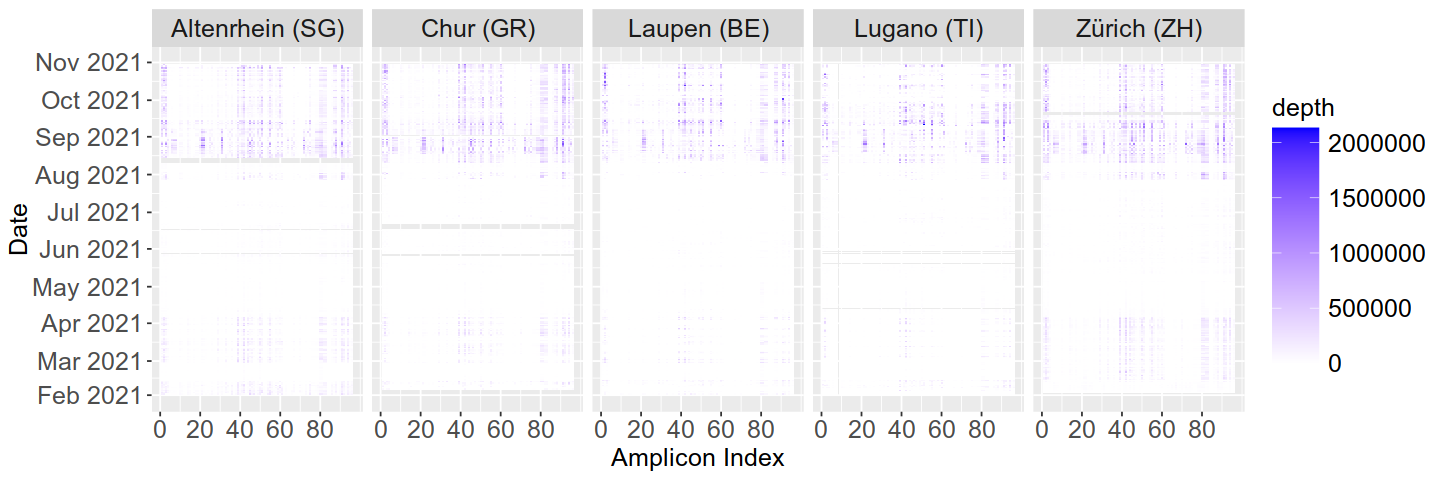

In [4]:
#plot the raw depth data
dt <- dt %>%
    mutate(amplicon = factor(amplicon, levels = unique(amplicon)))
# Get the number of unique amplicons
n_amplicons <- length(unique(dt$amplicon))

# Plotting the data
number = 15
options(repr.plot.width = 12, repr.plot.height = 4)
dt%>%
    ggplot(aes(as.numeric(amplicon), date)) +
    geom_tile(aes(fill = depth)) + facet_wrap(~location, ncol=6)+
    scale_fill_gradient(low = "white", high = "blue") +
    scale_y_date(breaks = date_breaks("1 month"), labels = date_format("%b %Y"), limits = c(min(dt$date), max(dt$date))) +   
    scale_x_continuous(breaks = seq(0, n_amplicons, by = 20), 
                       labels = seq(0, n_amplicons, by = 20)) +
    theme(axis.text.x = element_text(size = number), axis.text.y = element_text(size = number), 
                  axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),strip.text = element_text(size = number),
          legend.text = element_text(size = number),
         legend.title = element_text(size=number),legend.key.size = unit(1, "cm"), legend.key.height = unit(1, "cm"),legend.key.width = unit(1, "cm")) +
                  xlab("Date") + ylab("Entropy") +
    labs(y = "Date" ) +labs(x = "Amplicon Index")

ggsave("low_raw_depths.eps", path="FinalReport/figures", width = 12, height = 4)


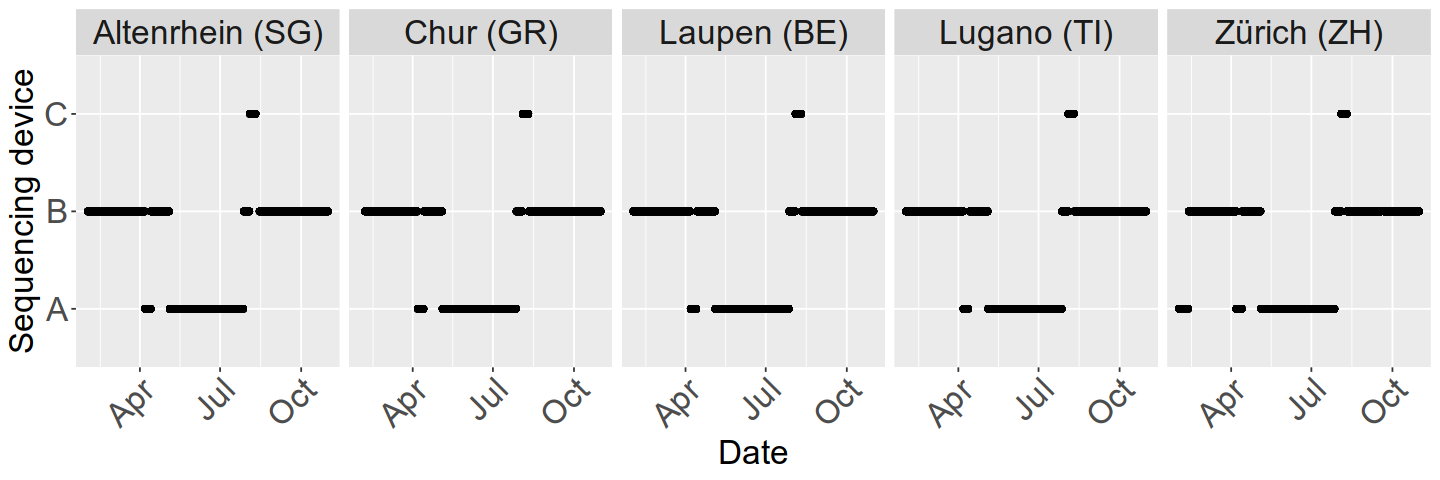

In [5]:
#Plots of which sequencing device was used over which period
options(repr.plot.width=12, repr.plot.height=4)
number=20
dt %>% ggplot(aes(date,sequencing_device)) + geom_point() + facet_wrap(~location, ncol = 6) + 
                    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = number), axis.text.y = element_text(size = number), 
                  axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),strip.text = element_text(size = number)) +
                  xlab("Date") + ylab("Sequencing device")

ggsave("batches.eps", path="FinalReport/figures", width = 12, height = 3)


[1] 184085.5

[1] 2132432

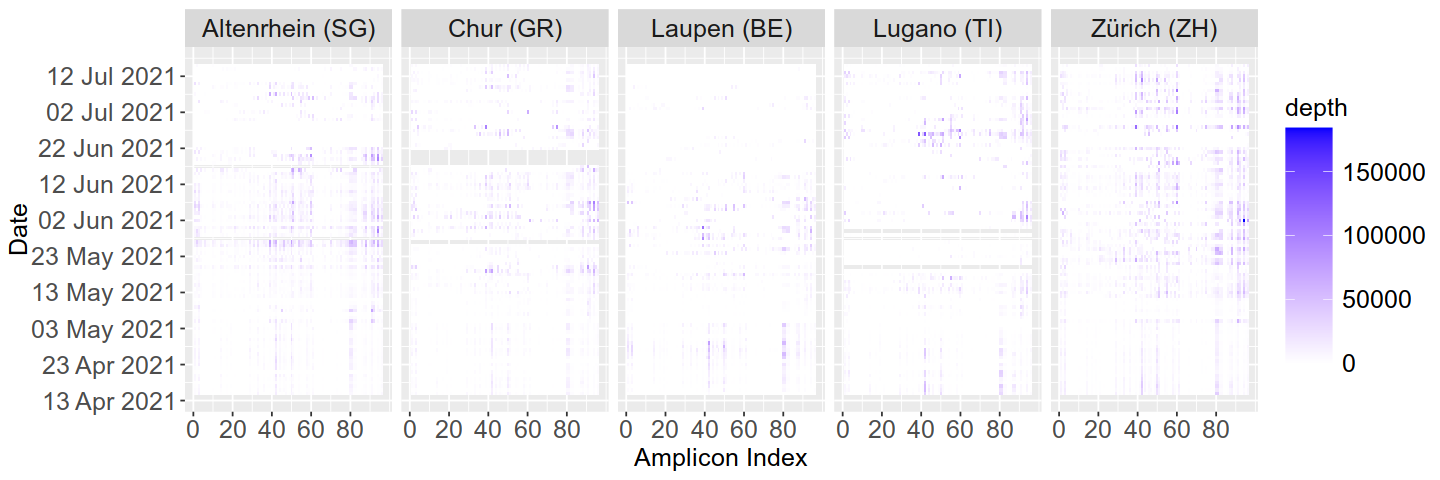

In [6]:
#visualize data from 15.04 to 15.07
options(repr.plot.width=6, repr.plot.height=6)

dt_lowest <- dt %>% filter(between(date,as.Date("2021-04-15"), as.Date("2021-07-15")))

dt_lowest <- dt_lowest %>%
    mutate(amplicon = factor(amplicon, levels = unique(amplicon)))

# Get the number of unique amplicons
n_amplicons <- length(unique(dt_lowest$amplicon))

# Plotting the data
number = 15
options(repr.plot.width = 12, repr.plot.height = 4)
dt_lowest%>%
    ggplot(aes(as.numeric(amplicon), date)) +
    geom_tile(aes(fill = depth)) + facet_wrap(~location, ncol=6)+
    scale_fill_gradient(low = "white", high = "blue") +
    scale_y_date(breaks = date_breaks("10 days"), labels = date_format("%d %b %Y")) +   
    scale_x_continuous(breaks = seq(0, n_amplicons, by = 20), 
                       labels = seq(0, n_amplicons, by = 20)) +
    theme(axis.text.x = element_text(size = number), axis.text.y = element_text(size = number), 
                  axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),strip.text = element_text(size = number),
          legend.text = element_text(size = number),
         legend.title = element_text(size=number),legend.key.size = unit(1, "cm"), legend.key.height = unit(1, "cm"),legend.key.width = unit(1, "cm")) +
                  xlab("Date") + ylab("Entropy") +
    labs(y = "Date" ) +labs(x = "Amplicon Index")

ggsave("lowest.eps", path="FinalReport/figures", width = 12, height = 4)

#display the maxima of both periods
max(dt_lowest$depth)
max(dt$depth)

# Concentration data preparation


In [7]:
# Import data
dt_viral = fread("Data/LowConcentrationData/concentration _data_2021.csv")

# Keep only 2021 data
dt_viral <- dt_viral %>% filter(format(collection_date, "%Y") == "2021")

# Rename columns
dt_viral <- dt_viral %>% rename(location = wastewater_treatment_plant.name, date = collection_date, 
                                concentration = gc_per_lww)

# Geneva doesn't have complete data and Vidy we don't have the sequence data + also incomplete
dt_viral <- dt_viral[!(location %in% c('STEP Vidy', 'STEP Aire'))]

dt_viral$date <- as.Date(dt_viral$date)

# Change the location names
dt_viral[, location := gsub("STEP Aire", "Genève (GE)", location)]
dt_viral[, location := gsub('ARA Altenrhein', 'Altenrhein (SG)', location)]
dt_viral[, location := gsub('ARA Werdhoelzli', "Zürich (ZH)", location)]
dt_viral[, location := gsub('CDA Lugano', 'Lugano (TI)', location)]
dt_viral[, location := gsub('ARA Sensetal', 'Laupen (BE)', location)]
dt_viral[, location := gsub('ARA Chur', 'Chur (GR)', location)]

table(dt_viral$target) # We see that we don't really have any SN2 so let's just look at SN1
dt_viral <- dt_viral %>% filter(target %in% c('SARS-N1'))

# We have two values of concentration for each day and location -> we will take the average, as done in the concentration data 
# for 2022-23. We will also change the unit: here we have gene copies per litre of WW, in 2022-23 data we have it in gene copies
# per millilitre -> we will divide the data by 1000 to get gc per mL
# Assay is the same for all here: n1mhv
dt_viral[, concentration := concentration / 1000]
dt_viral <- dt_viral %>% group_by(location, date, target) %>% 
                        summarize(concentration_mean = sum(concentration) / 2)

# There is an outlier in Zürich that we will remove
dt_viral <- dt_viral %>% filter(concentration_mean <= 300)

head(dt_viral)



  IAV-M   IBV-M   RSV-N SARS-N1 SARS-N2 
     15      15      15    3360      15 

`summarise()` has grouped output by 'location', 'date'. You can override using the `.groups` argument.

location        date       target  concentration_mean
1 Altenrhein (SG) 2021-02-01 SARS-N1  13.88438         
2 Altenrhein (SG) 2021-02-02 SARS-N1  13.26759         
3 Altenrhein (SG) 2021-02-03 SARS-N1 107.02531         
4 Altenrhein (SG) 2021-02-04 SARS-N1  27.03965         
5 Altenrhein (SG) 2021-02-05 SARS-N1  32.60839         
6 Altenrhein (SG) 2021-02-07 SARS-N1  21.65992

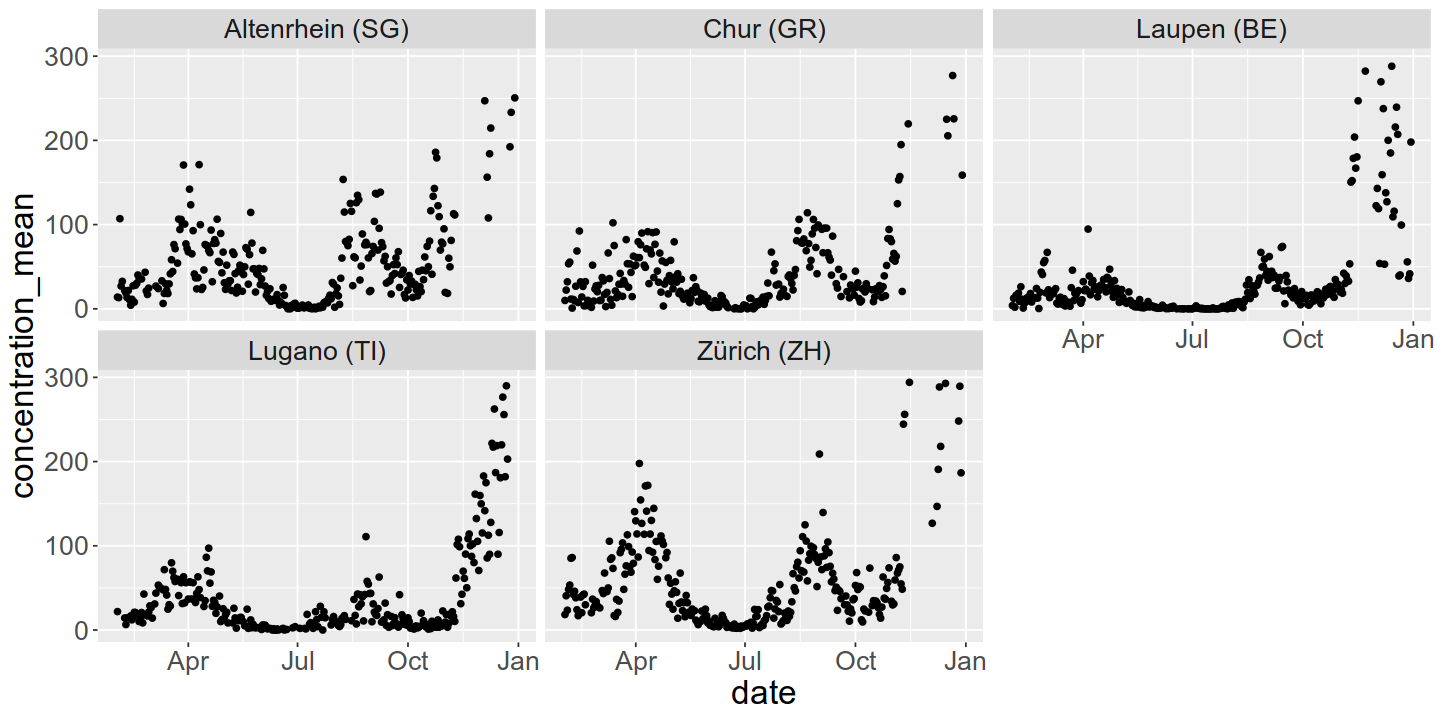

In [8]:
#plot the concentrations
options(repr.plot.width=12, repr.plot.height=6)
dt_viral %>%  ggplot(aes(date, concentration_mean)) + geom_point() + facet_wrap(~location) + theme(text=element_text(size=20))


[1] "2021-02-01"

[1] "2021-10-31"

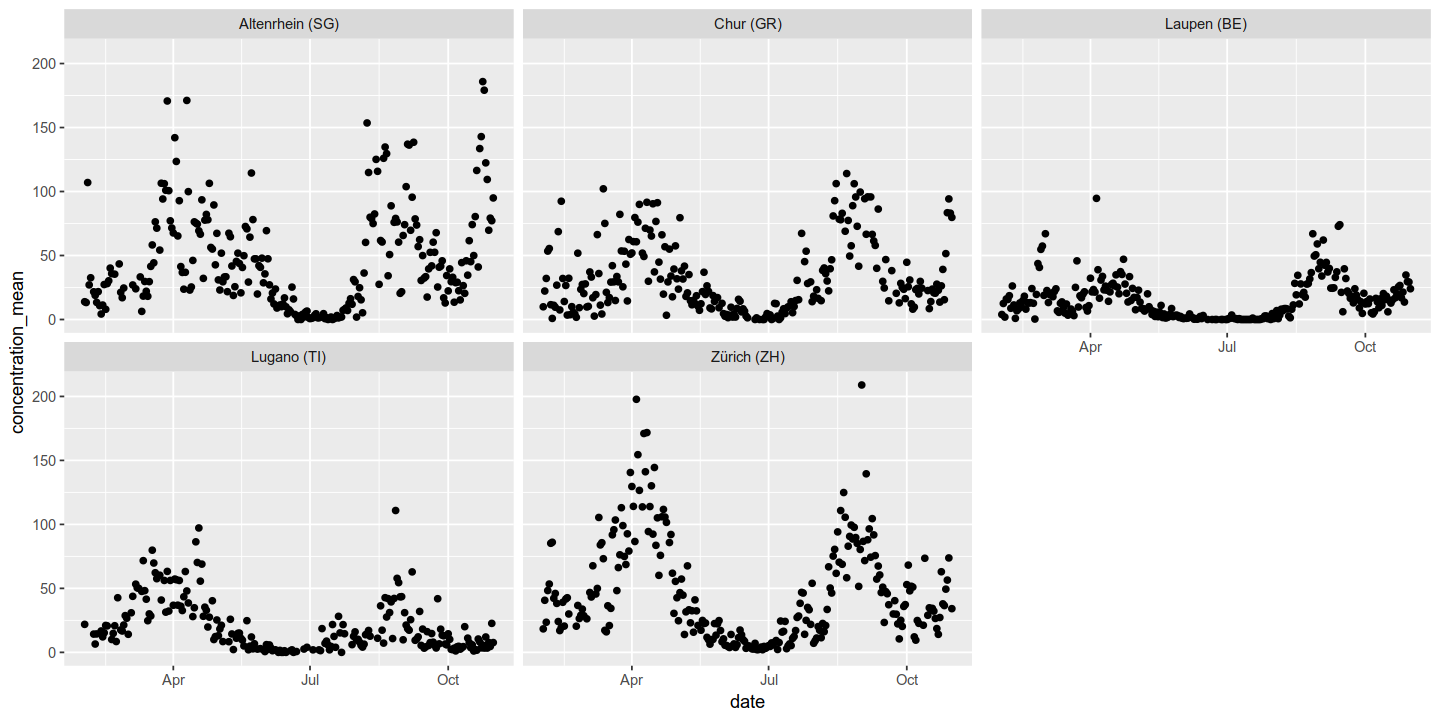

In [9]:
# Cut the high concentrations
options(repr.plot.width=12, repr.plot.height=6)

dt_viral <- dt_viral %>% filter(date < as.Date("2021-11-01"))
min(dt_viral$date)
max(dt_viral$date)

#plot it
dt_viral %>%  ggplot(aes(date, concentration_mean)) + geom_point() + facet_wrap(~location)


# Exploratory analysis
## Calculate entropy

In [10]:
#normalizing by the sum of the read depths per day and per location
sum_normalization <- dt %>%
    group_by(location, date) %>%   
    mutate(sum = sum(depth)) %>%  #for each day and location, we calculate the the sum of the depths over all amplicons
    mutate(sum_norm = (depth/sum)) %>%
    mutate(sum_norm = replace_na(sum_norm, 0))  #because of days where all the reads are 0, there is division by 0 -> we replace the created NANs with 0.
#------------------------------------------------------
#calculating entropy with this normalization: version where we only keep location, date and entropy in order to calculate spectral density. 
sum_entropy_psd <- sum_normalization %>%   
    mutate(product = -(sum_norm * log(sum_norm))) %>%
    mutate(product = replace_na(product, 0)) %>%
    group_by(location, date) %>%
    summarize(entropy = sum(product))
head(sum_entropy_psd)
#-------------------------------------------------------
#define a new data table with entropy so that we can merge it with concentrations and keep the delay.
sum_entropy<- sum_normalization %>%   
    mutate(product = -(sum_norm * log(sum_norm))) %>%
    mutate(product = replace_na(product, 0)) %>%
    group_by(location, date) %>%
    mutate(entropy = sum(product))
head(sum_entropy)

`summarise()` has grouped output by 'location'. You can override using the `.groups` argument.

location        date       entropy 
1 Altenrhein (SG) 2021-02-01 3.489366
2 Altenrhein (SG) 2021-02-02 3.694602
3 Altenrhein (SG) 2021-02-03 3.944490
4 Altenrhein (SG) 2021-02-04 4.036758
5 Altenrhein (SG) 2021-02-05 3.972737
6 Altenrhein (SG) 2021-02-06 3.881639

batch              date       location    amplicon depth   sample_day
1 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X0       13249.0 1         
2 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X1       81265.0 1         
3 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X2        8890.5 1         
4 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X3       11403.0 1         
5 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X4           0.0 1         
6 20210416_HYTGGDRXX 2021-02-01 Lugano (TI) X5         487.0 1         
  test_day delay sequencing_device sequencing1 sequencing2 sequencing3 sum     
1 2        3     B                 0           1           0           457719.5
2 2        3     B                 0           1           0           457719.5
3 2        3     B                 0           1           0           457719.5
4 2        3     B                 0           1           0           457719.5
5 2        3     B                 0           1           0           457719.5
6 2        3     B                 0           1           0           457719.5
  sum_norm   product     entropy 
1 0.02894568 0.102535263 2.524436
2 0.17754323 0.306890781 2.524436
3 0.01942347 0.076553195 2.524436
4 0.02491264 0.091986926 2.524436
5 0.00000000 0.000000000 2.524436
6 0.00106397 0.007283673 2.524436

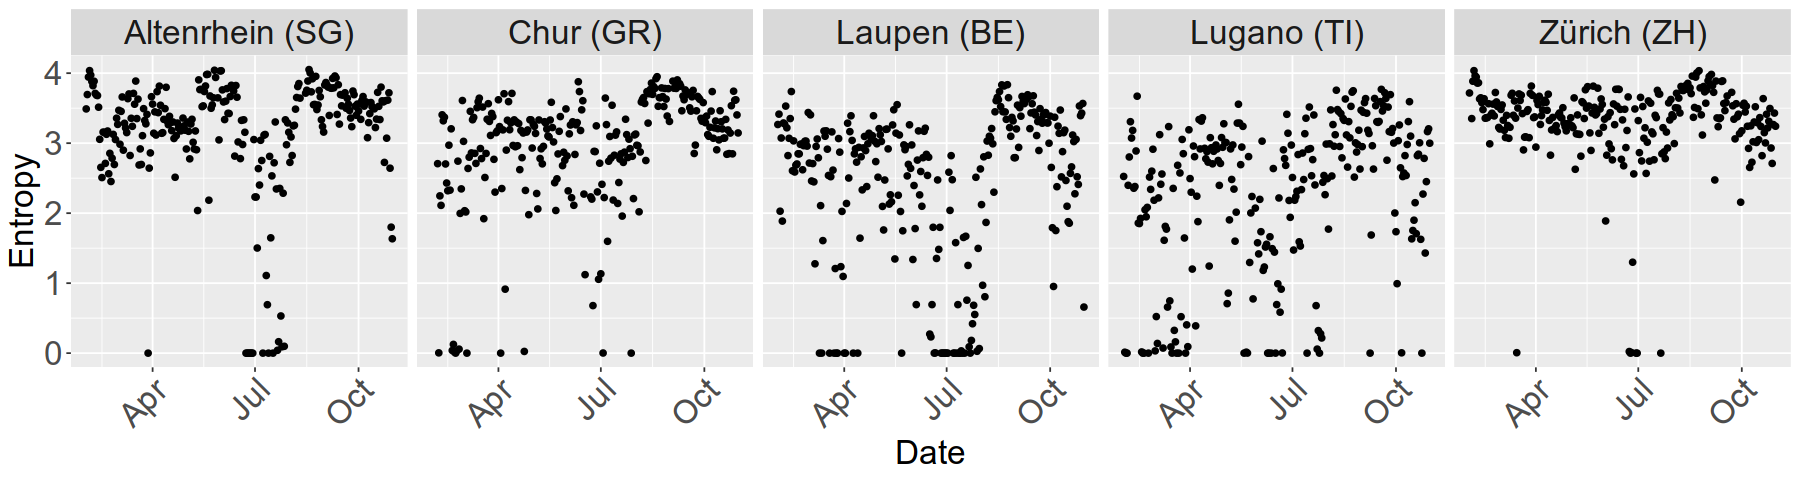

In [11]:
#visualisation of the entropy for all locations

#count the number of different locations
num_locations <- length(unique(sum_entropy$location))

options(repr.plot.width=15, repr.plot.height=4)

#letter size
number = 20

entropy_plot <- sum_entropy_psd %>%  ggplot(aes(date, entropy)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
                    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = number), axis.text.y = element_text(size = number), 
                  axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),strip.text = element_text(size = number)) +
                  xlab("Date") + ylab("Entropy")
print(entropy_plot)



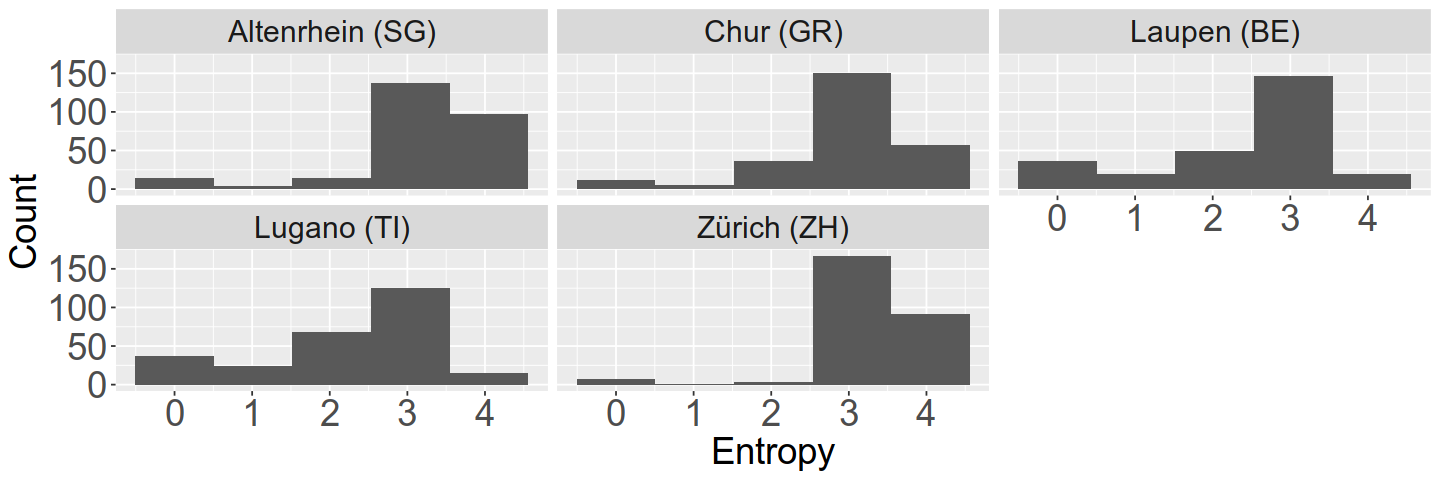

In [12]:
#frequency of the entropy values
#remark: the .eps has correct dimensions as opposed to the plot in this jupyter notebook
options(repr.plot.width=12, repr.plot.height=4)
number = 18

ggplot(sum_entropy_psd, aes(x = entropy)) +
  geom_histogram(bins = 5) + 
  facet_wrap(~location) + 
  theme(axis.text.x = element_text(size = 22), axis.text.y = element_text(size = 22), 
          axis.title.x = element_text(size = 22), axis.title.y = element_text(size = 22),strip.text = element_text(size = number)) +
  xlab("Entropy") + ylab("Count")


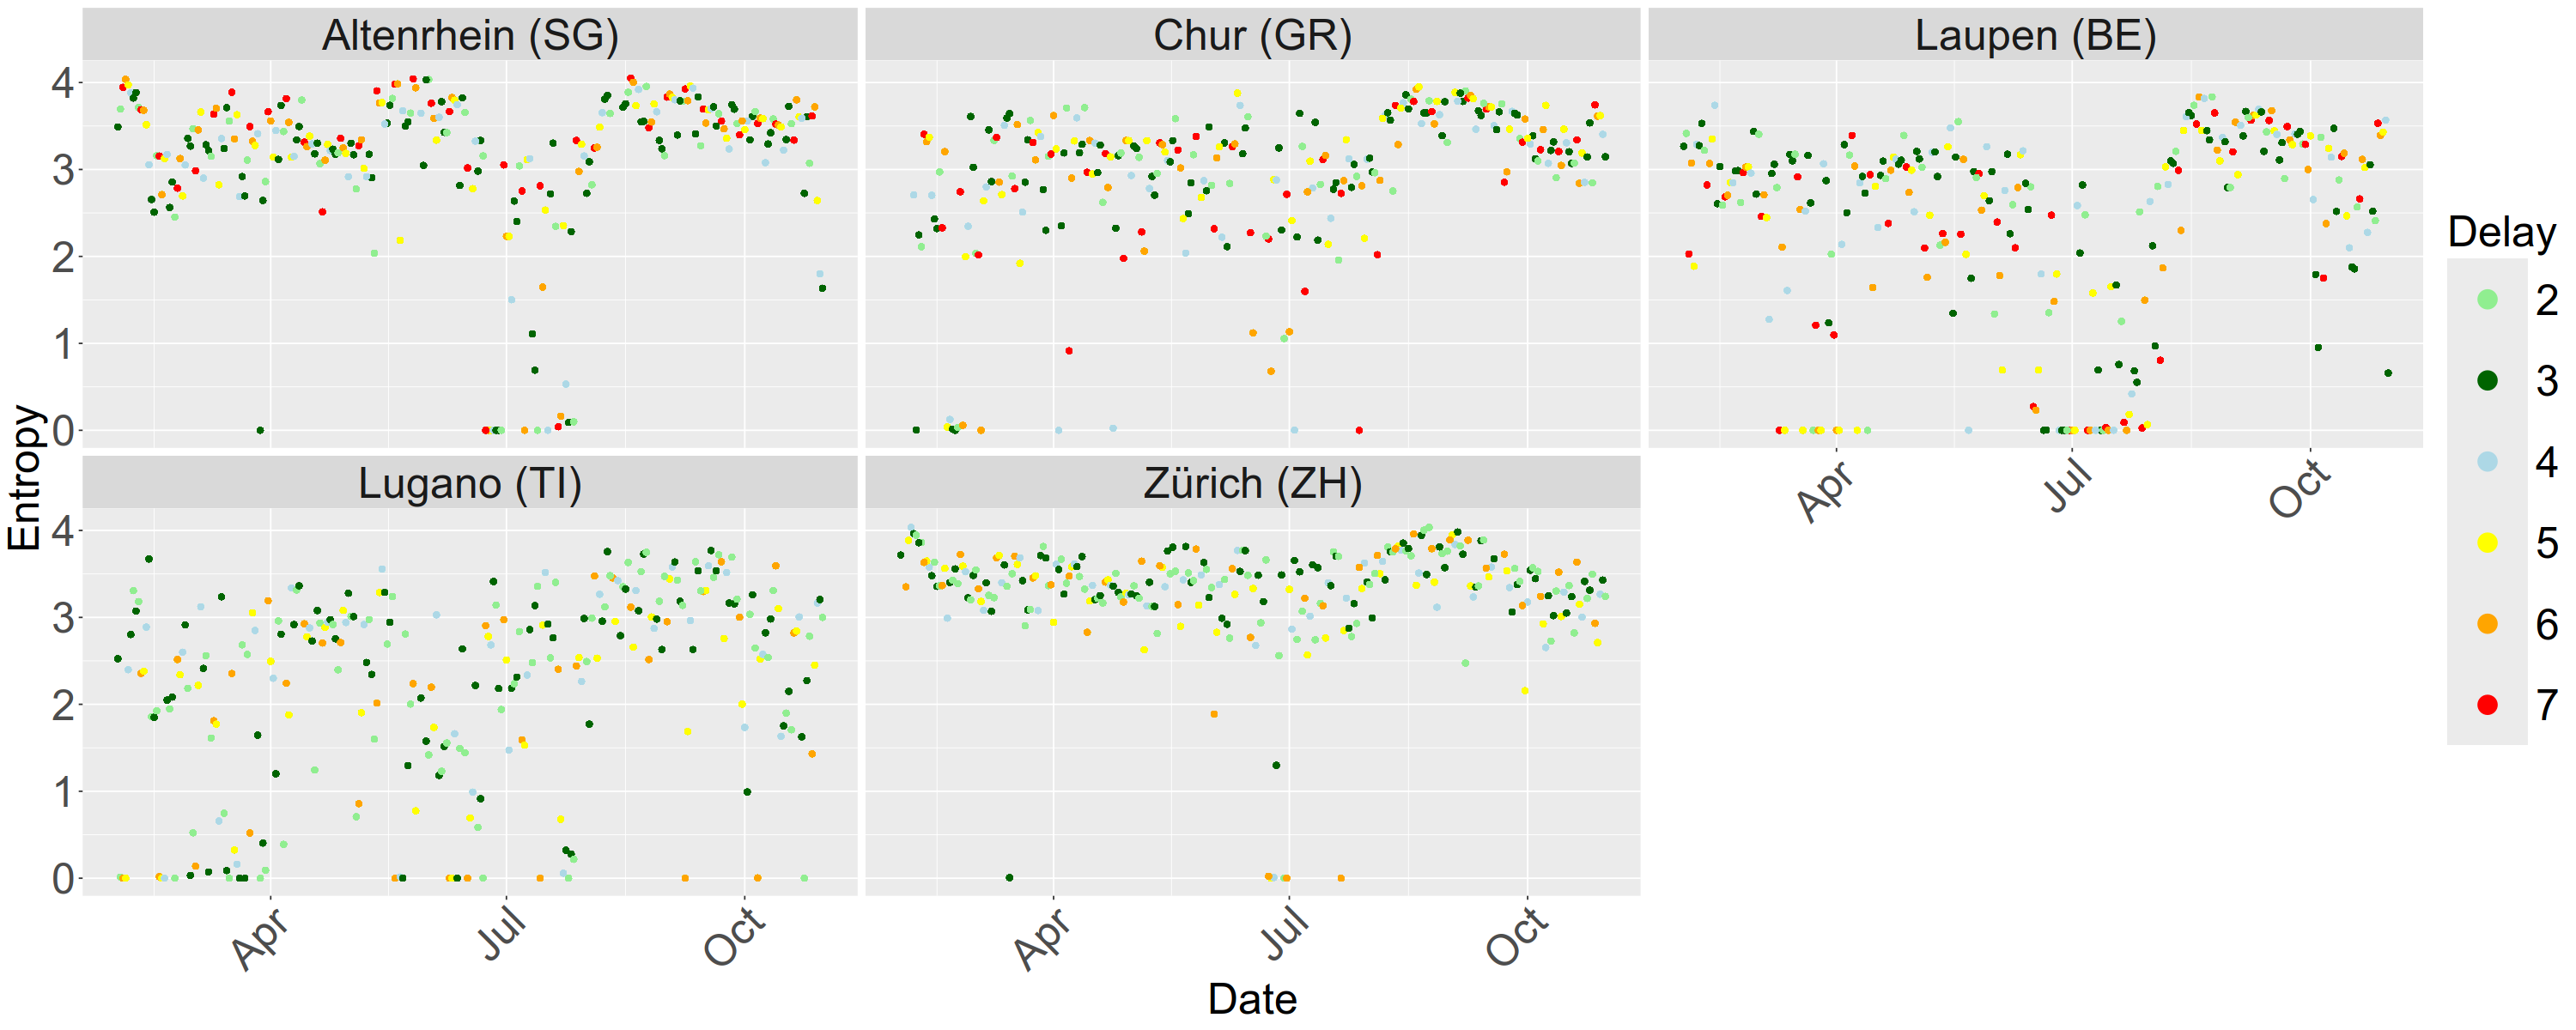

In [13]:
#plot of entropy with colored delays
options(repr.plot.width=25, repr.plot.height=10)
custom_colors <- c("2" = "lightgreen", "3" = "darkgreen" , "4" = "lightblue", "5" = "yellow" , "6"= "orange", "7" = "red")
sum_entropy %>%  
    ggplot(aes(date, entropy, color = factor(delay))) + geom_point() + facet_wrap(~location) + 
    scale_color_manual(name = "Delay", values = custom_colors) + labs(x="Date", y= "Entropy") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 30), axis.text.y = element_text(size = 30), 
          axis.title.x = element_text(size = 30), axis.title.y = element_text(size = 30),strip.text = element_text(size = 30), legend.text = element_text(size = 30),
         legend.title = element_text(size=30), legend.key.size = unit(2.5, "cm"), legend.key.height = unit(2, "cm"),legend.key.width = unit(2, "cm") ) +
     guides(color = guide_legend(override.aes = list(size = 6))) 


In [14]:
#distribution of different delay classes

#define data that only keep the X0 amplicon in order to not repeat the delays and entropy 96 times for one day
sum_entropy_distinct <- sum_entropy %>% distinct(date, location, .keep_all = TRUE)

for (loc in unique(sum_entropy_distinct$location)){
    rep <- sum_entropy_distinct %>% filter(location == loc)
    print(paste("This is the distribution of delays for ", loc))
    print(table(rep$delay))
}

[1] "This is the distribution of delays for  Lugano (TI)"

 2  3  4  5  6 
76 78 38 38 39 
[1] "This is the distribution of delays for  Zürich (ZH)"

 2  3  4  5  6 
75 77 39 39 39 
[1] "This is the distribution of delays for  Chur (GR)"

 2  3  4  5  6  7 
38 75 38 37 36 37 
[1] "This is the distribution of delays for  Altenrhein (SG)"

 2  3  4  5  6  7 
39 78 38 37 37 38 
[1] "This is the distribution of delays for  Laupen (BE)"

 2  3  4  5  6  7 
39 78 39 39 39 39 


In [15]:
#Create a latex table of the delay frequencies

library(xtable)
library(knitr)

locations <- unique(sum_entropy$location)
delays <- 2:7
table_data <- data.frame(Location = locations)

for (delay in delays) {
  table_data[[as.character(delay)]] <- sapply(locations, function(loc) {
    sum(sum_entropy_distinct$delay[sum_entropy_distinct$location == loc] == delay)
  })
}

# Convert the data frame to a LaTeX table
latex_table <- xtable(table_data)

# Print the LaTeX table with booktabs style
print(latex_table, include.rownames = FALSE, booktabs = TRUE)


% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Aug 12 15:13:27 2024
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrr}
  \toprule
Location & 2 & 3 & 4 & 5 & 6 & 7 \\ 
  \midrule
Lugano (TI) &  76 &  78 &  38 &  38 &  39 &   0 \\ 
  Zürich (ZH) &  75 &  77 &  39 &  39 &  39 &   0 \\ 
  Chur (GR) &  38 &  75 &  38 &  37 &  36 &  37 \\ 
  Altenrhein (SG) &  39 &  78 &  38 &  37 &  37 &  38 \\ 
  Laupen (BE) &  39 &  78 &  39 &  39 &  39 &  39 \\ 
   \bottomrule
\end{tabular}
\end{table}


# Low entropy data

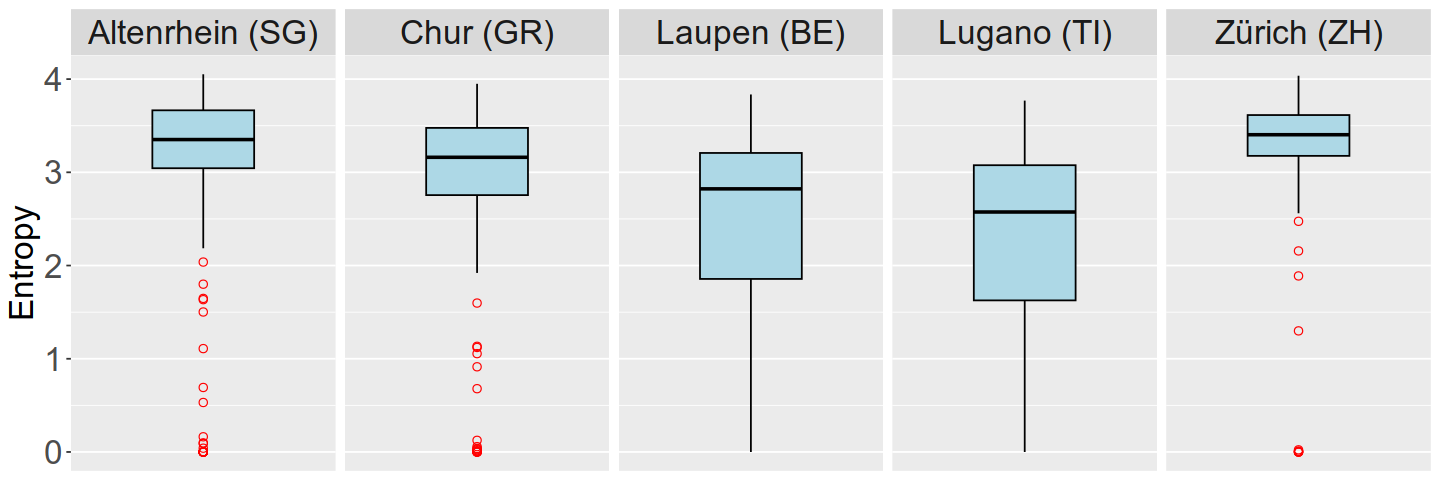

In [16]:
options(repr.plot.width=12, repr.plot.height=4)

#plot the boxplot of entropy data in all locations
ggplot(sum_entropy_psd, aes(y = entropy)) +
  geom_boxplot(fill = "lightblue", color = "black", outlier.colour="red", outlier.shape=1,
             outlier.size=2, notch=FALSE) +
              labs(y = "Entropy") + facet_wrap(~location, ncol=6)+
              theme(axis.text.y = element_text(size = 20), 
           axis.title.y = element_text(size = 20), strip.text = element_text(size = 20)) + scale_x_discrete()

ggsave("low_boxplot_entropy.eps", path="FinalReport/figures", width =12, height =4)


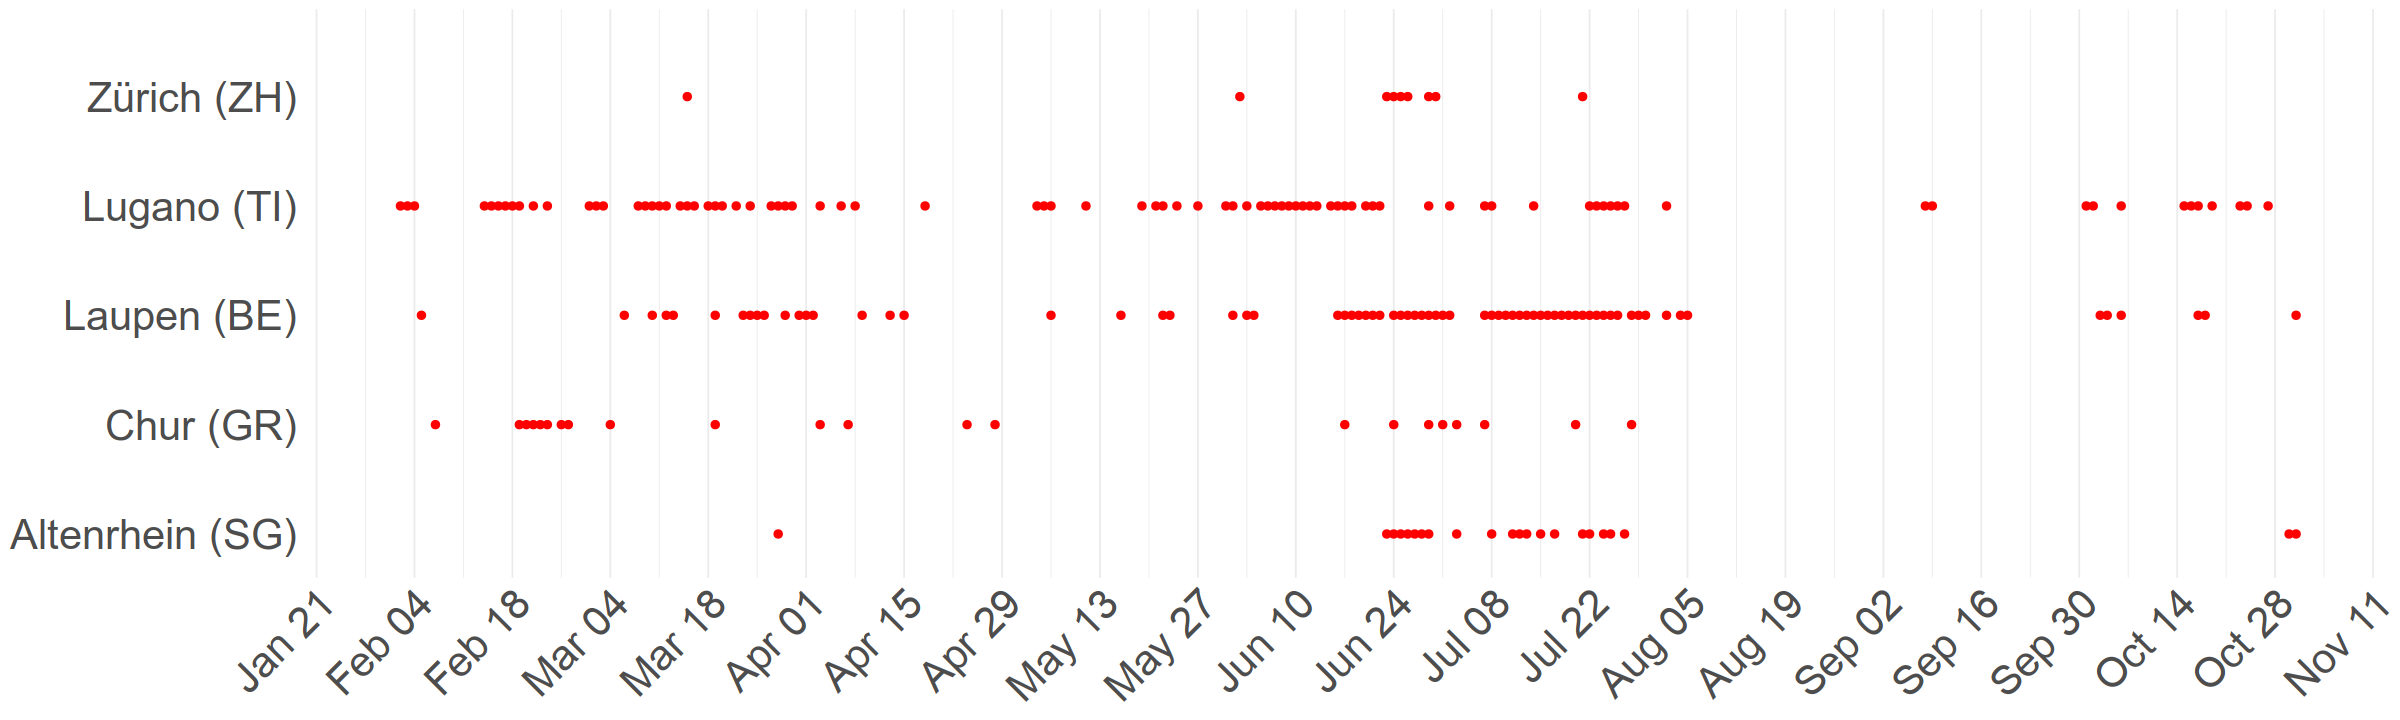

In [17]:
options(repr.plot.width=20, repr.plot.height=6)

# analyzing data with entropy <2
threshold <- 2

#filter data for low entropy values
low_entropy_data <- sum_entropy_psd %>% filter(entropy < threshold)

#plot the low entropy data for each location
ggplot(low_entropy_data, aes(x = date, y = location)) +
  geom_point(size = 2, color = "red") +
  scale_y_discrete(expand = expansion(mult = c(0.1, 0.2))) +  # Add space at top and bottom of y-axis
  scale_x_date(date_labels = "%b %d", date_breaks = "14 days") +
  labs(x = NULL, y = NULL, title = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 25),
        axis.text.y = element_text(size = 25),
        panel.grid.major.y = element_blank(),   #Remove horizontal grid lines
        panel.grid.minor.y = element_blank())

ggsave("low_entropy_low.eps", path="FinalReport/figures", width =20, height = 8)


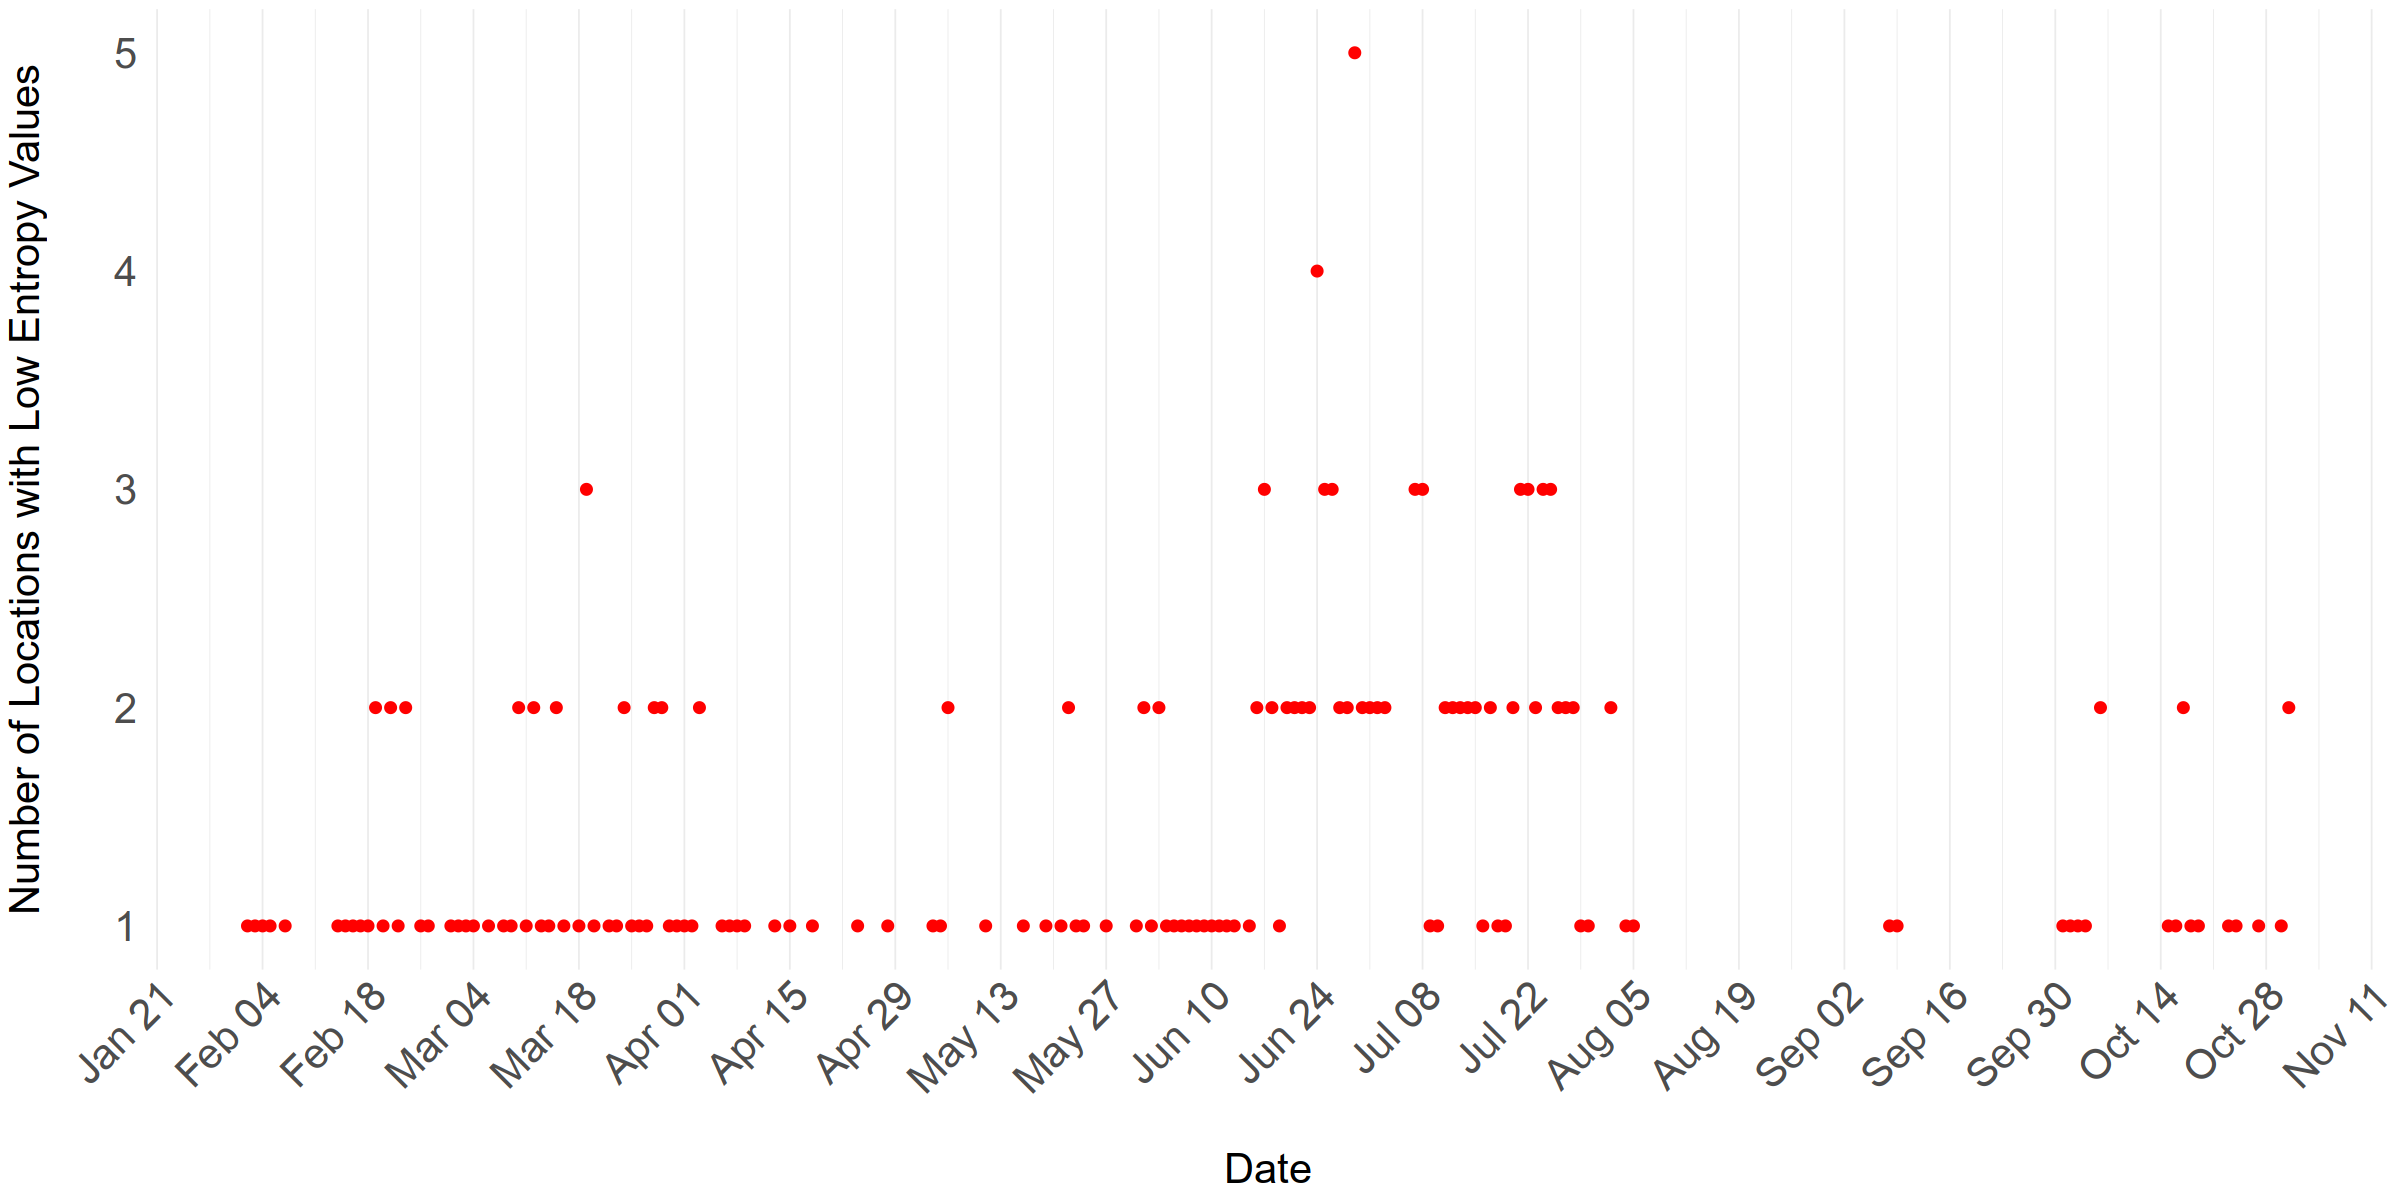

In [18]:
options(repr.plot.width=20, repr.plot.height=10)

# Count the number of location that have a low entropy value on a given day
low_entropy_counts <- low_entropy_data %>%
  group_by(date) %>%
  summarise(count = n()) #n() is a function that returns the number of rows in each group

# Plot
ggplot(low_entropy_counts, aes(x = date, y = count)) +
  geom_point(size=3, color = "red") +
  scale_y_continuous(breaks = 1:6) +
  scale_x_date(date_labels = "%b %d", date_breaks = "14 days") +
  labs(x = "Date", y = "Number of Locations with Low Entropy Values", title = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 25),
        axis.text.y = element_text(size = 25), axis.title.x = element_text(size = 25, margin = margin(t=30)),
        axis.title.y = element_text(size = 25, 
        margin = margin(r=40)),
        panel.grid.major.y = element_blank(),  # Remove horizontal grid lines
        panel.grid.minor.y = element_blank())

ggsave("low_entropy_count_low.eps", path="FinalReport/figures", width =20, height = 10)


# Coverage

In [19]:
#definition of coverage dataframes with different thresholds
coverage_threshold100 <- dt %>% mutate(depth = ifelse(depth <=100,0,depth)) %>% group_by(location, date) %>%  
                            summarize(coverage = sum(depth != 0)/96)

coverage_threshold200 <- dt %>% mutate(depth = ifelse(depth <=200,0,depth)) %>% group_by(location, date) %>% 
                            summarize(coverage = sum(depth != 0)/96)

coverage_threshold1000 <- dt %>% mutate(depth = ifelse(depth <=1000,0,depth)) %>% group_by(location, date) %>% 
                            summarize(coverage = sum(depth != 0)/96)


`summarise()` has grouped output by 'location'. You can override using the `.groups` argument.`summarise()` has grouped output by 'location'. You can override using the `.groups` argument.`summarise()` has grouped output by 'location'. You can override using the `.groups` argument.

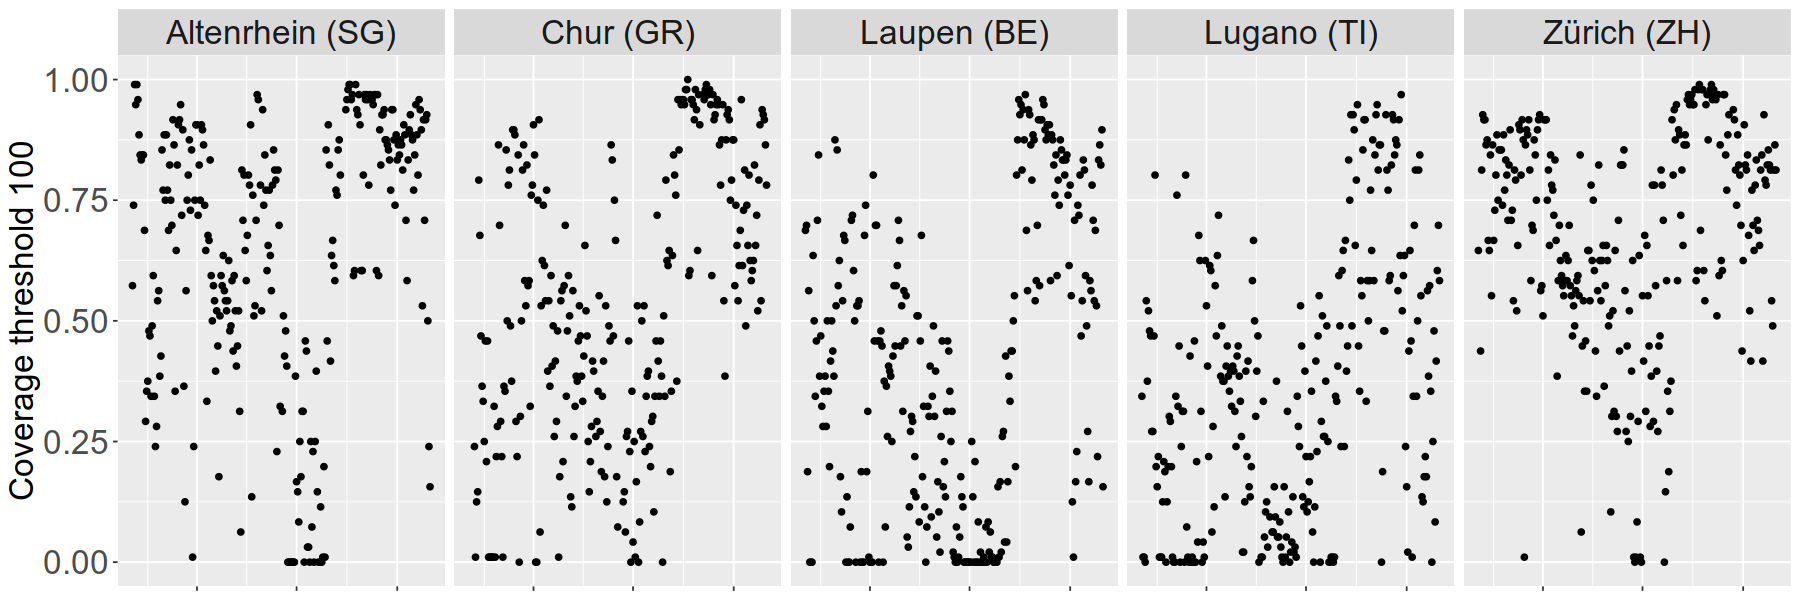

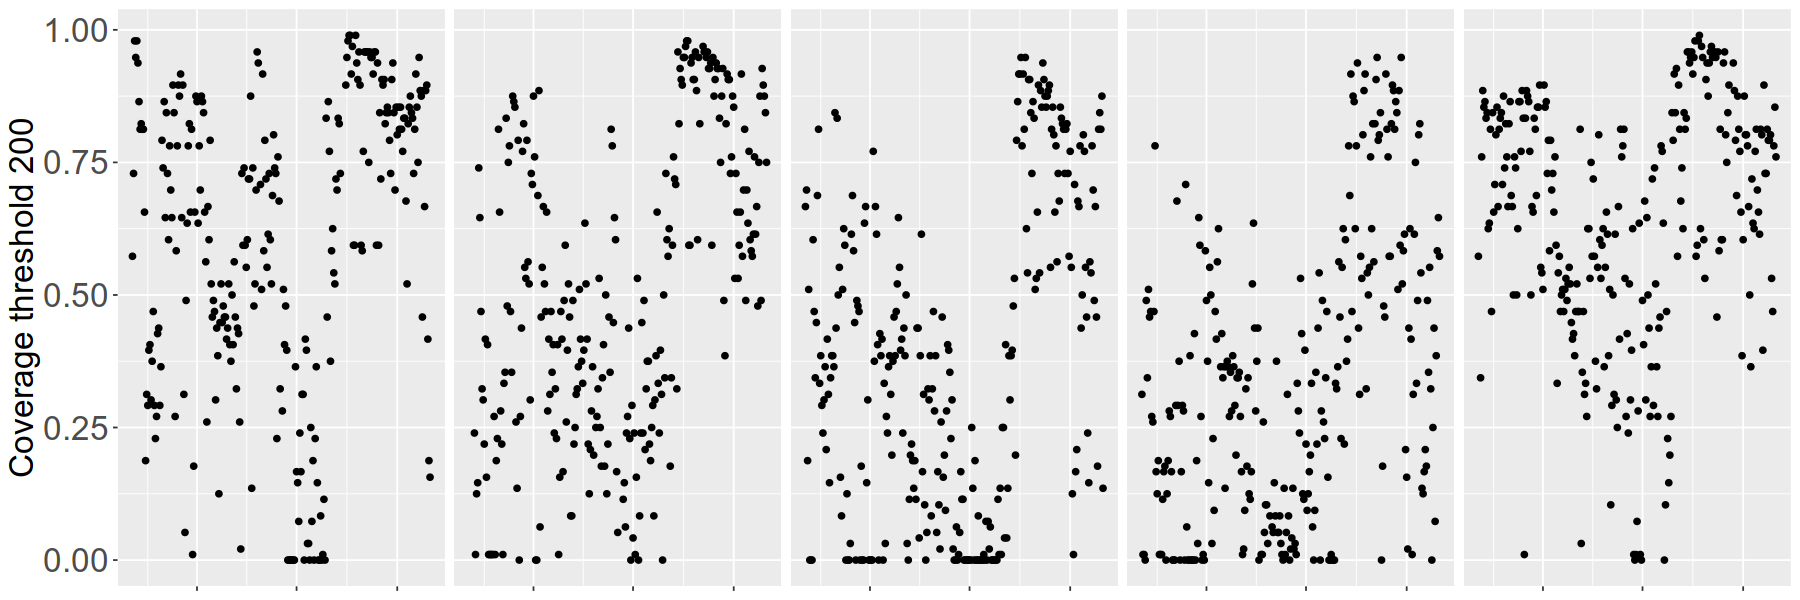

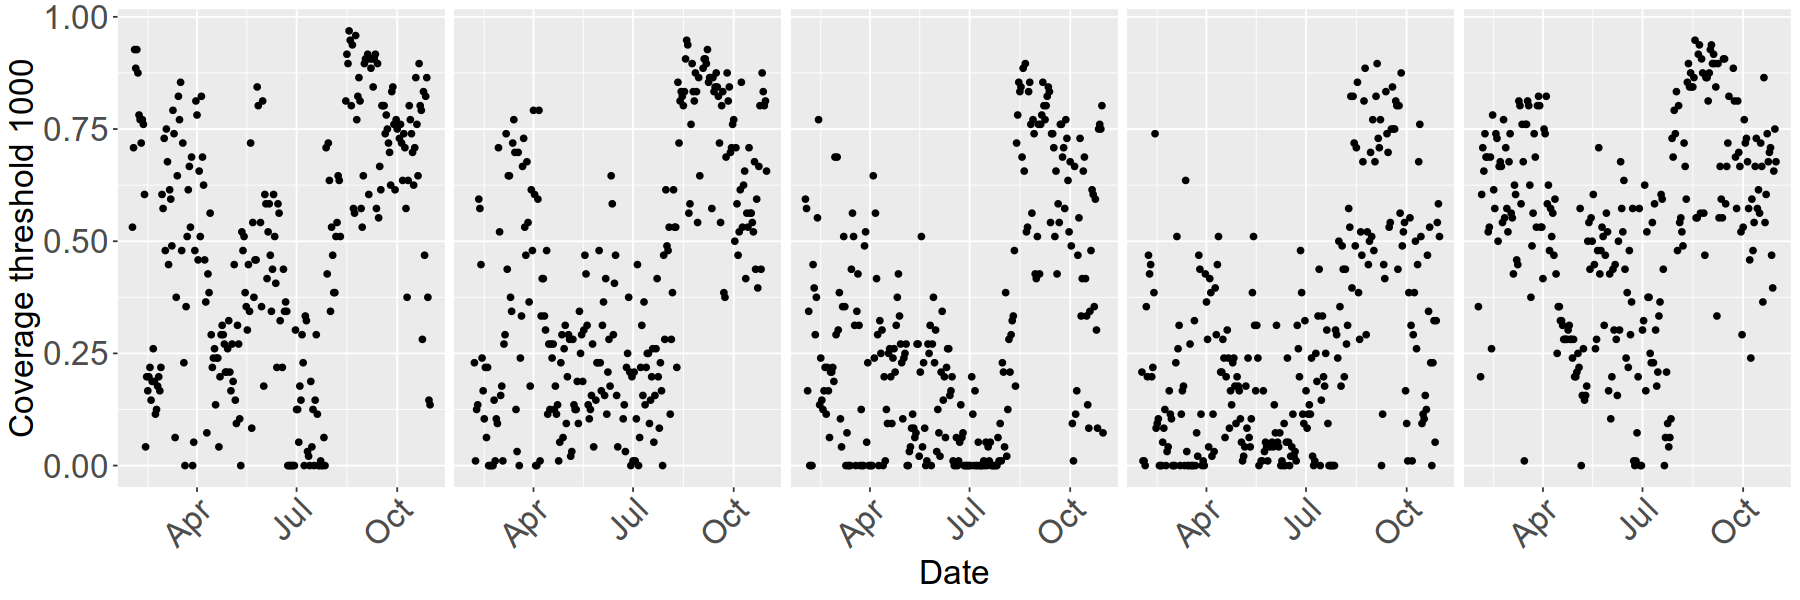

In [20]:
#visualisation of the coverage for all locations
#First let us define the individual plots for each threshold.

options(repr.plot.width=15, repr.plot.height=5)

#the individual plots
plot_100 <- coverage_threshold100 %>%  ggplot(aes(date, coverage)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
            theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.text.y = element_text(size = 20), axis.title.y = element_text(size = 20),strip.text = element_text(size = 20) ) + ylab("Coverage threshold 100")

plot_200 <- coverage_threshold200 %>%  ggplot(aes(date, coverage)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
        theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.text.y = element_text(size = 20), axis.title.y = element_text(size = 20), strip.text = element_blank(),
        strip.background = element_rect(fill = "lightgrey")) + ylab("Coverage threshold 200")

plot_1000 <- coverage_threshold1000 %>%  ggplot(aes(date, coverage)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 20), axis.text.y = element_text(size = 20), axis.title.x = element_text(size = 20), axis.title.y = element_text(size = 20), strip.text = element_blank(),
        strip.background = element_rect(fill = "lightgrey"))+ylab("Coverage threshold 1000") +xlab("Date")


print(plot_100)
print(plot_200)
print(plot_1000)
      



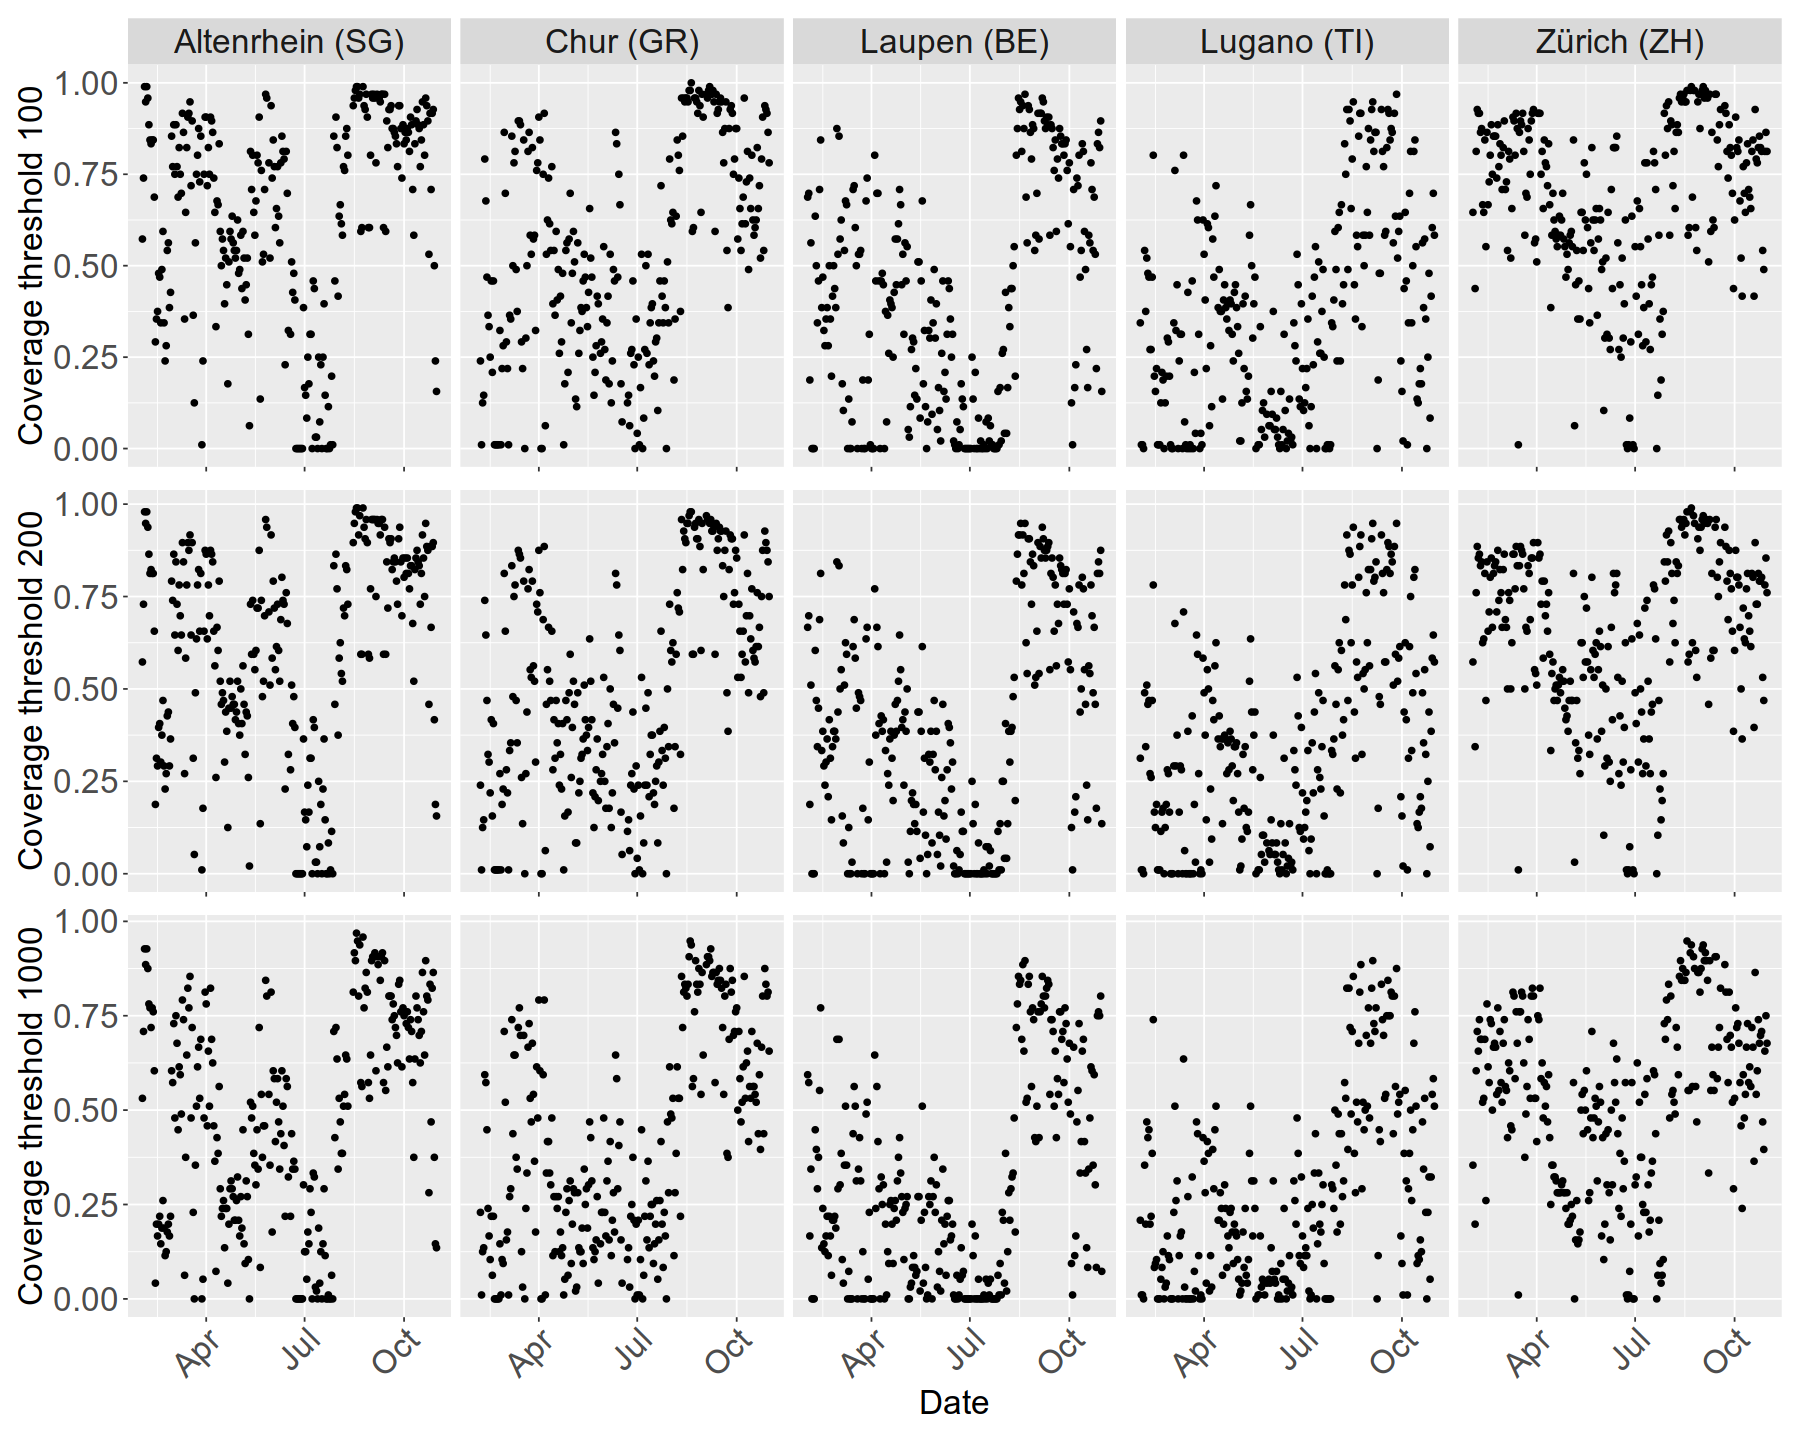

In [21]:
# Combine the plots into one figure:

#Adapt the size of the final plot
options(repr.plot.width = 15, repr.plot.height = 12) 

#Load the necessary library
library(patchwork)

#Combine
combined_plot_coverage <- plot_100 + plot_200 + plot_1000 + 
  plot_layout(ncol = 1) + # Arranges the plots in one column
  plot_annotation(title = NULL)

print(combined_plot_coverage)

#Save the combined plot


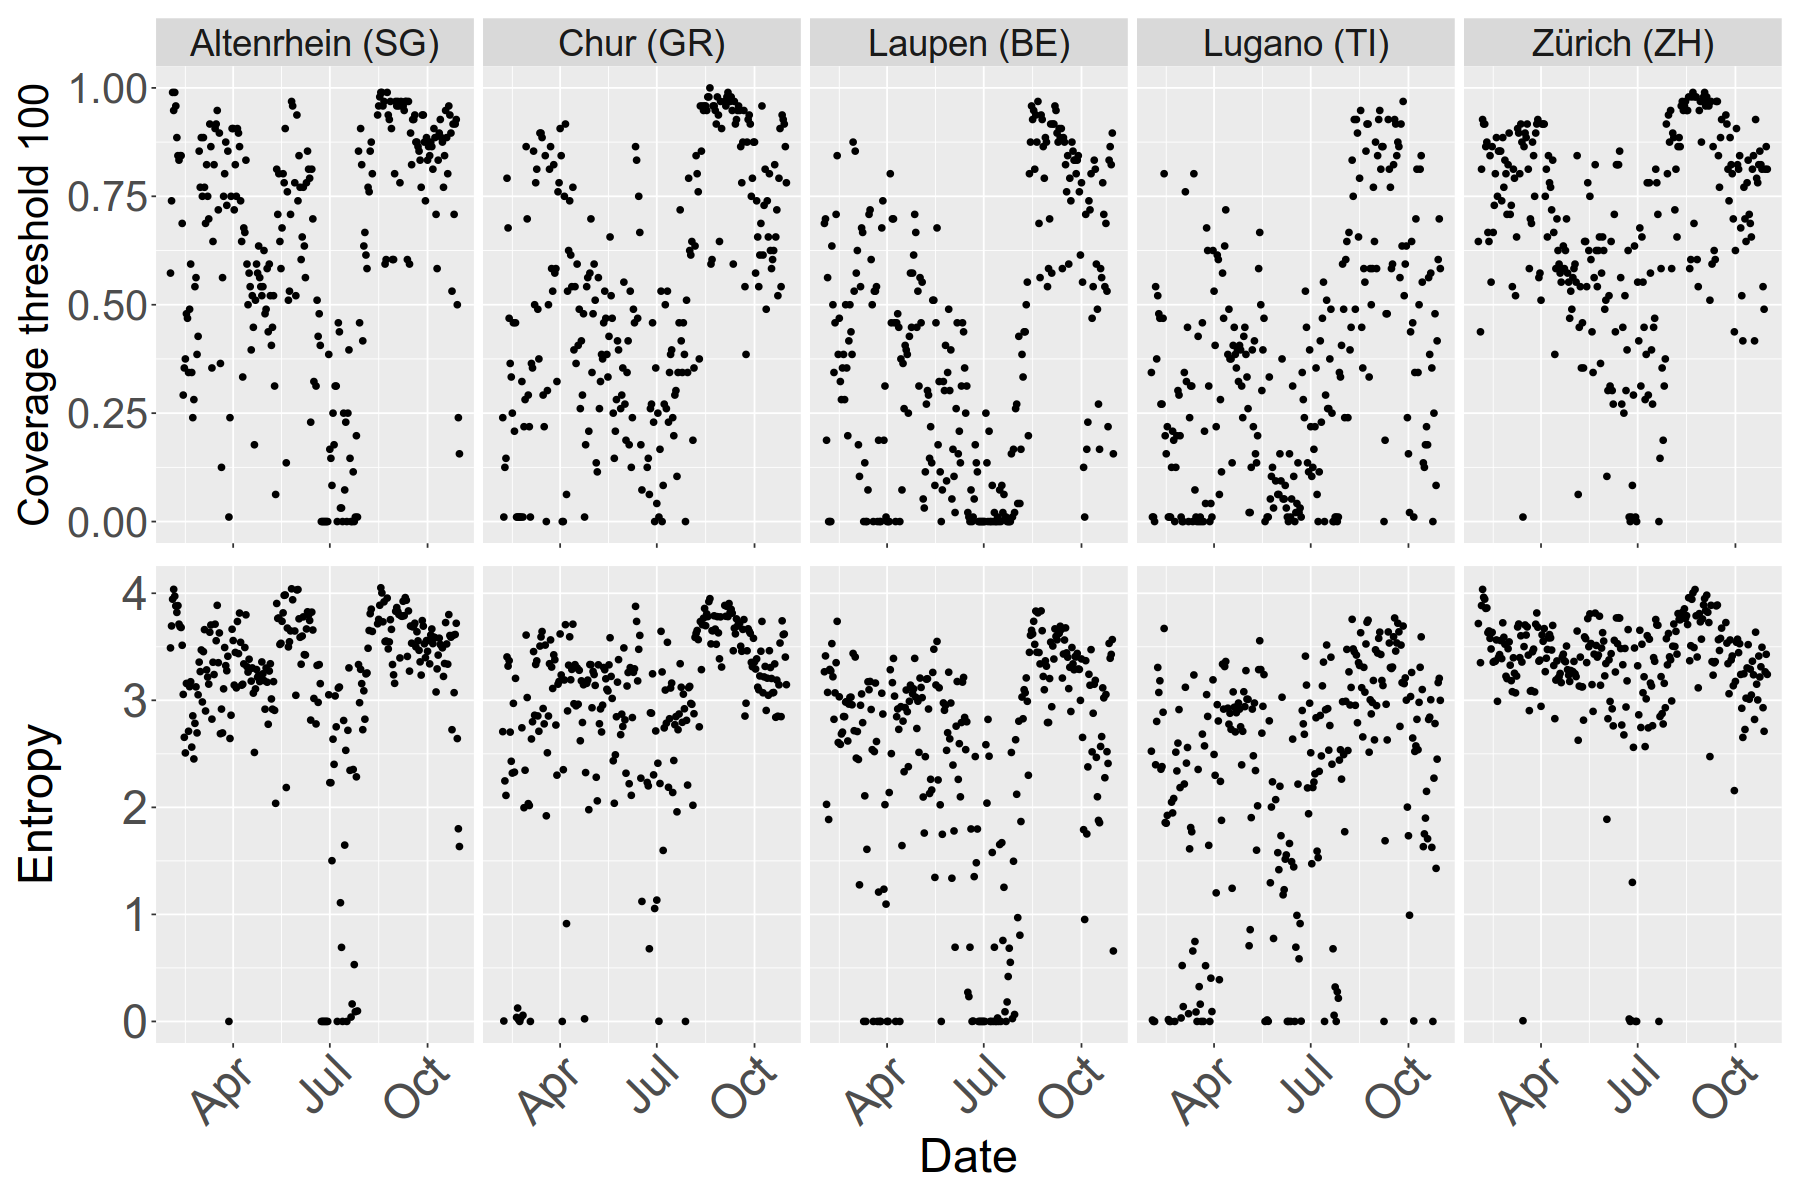

In [22]:
#Combine entropy and coverage in one plot
number = 28

#Adapt the size of the final plot
options(repr.plot.width = 15, repr.plot.height = 10)

#redefine coverage plot in order to combine it with entropy
plot_100_combined <- coverage_threshold100 %>%  ggplot(aes(date, coverage)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
        theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.text.y = element_text(size = 25), axis.title.y = element_text(size = 25), 
        strip.text = element_text(size = 22),) + ylab("Coverage threshold 100")

#redefine the entropy plot
entropy_plot_combined <- sum_entropy_psd %>%  ggplot(aes(date, entropy)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
                    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = number), axis.text.y = element_text(size = number), 
                  axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),strip.text = element_blank()) +
                  xlab("Date") + ylab("Entropy")

#Combine these two plots
entropy_coverage_plot <- plot_100_combined + entropy_plot_combined + 
  plot_layout(ncol = 1) + # Arranges the plots in one column
  plot_annotation(title = NULL)

print(entropy_coverage_plot)

ggsave("low_combined_entropy_coverage.eps", plot = entropy_coverage_plot, path="FinalReport/figures", width = 15, height = 10)



### Compare coverage and entropy with correlation analysis

In [23]:
#create a datatable containing both coverage and entropy
coverage_entropy_together <- merge(sum_entropy_psd, coverage_threshold200, by = c("date", "location"))

#calculate the corelation
correlation_coverage_entropy <- data.frame(location = character(), 
                      pearson_r = numeric(), 
                      spearman_s = numeric(), 
                      stringsAsFactors = FALSE)

for (loc in unique(coverage_entropy_together$location)){
    data_by_location <- coverage_entropy_together %>% filter(location == loc)
    r <-round(cor(data_by_location$entropy, data_by_location$coverage),2)
    s <-round(cor(data_by_location$entropy, data_by_location$coverage, method = 'spearman'),2)
    correlation_coverage_entropy <- rbind(correlation_coverage_entropy, data.frame(location = loc, pearson_r = r, spearman_s = s))
    
}

print(correlation_coverage_entropy)

         location pearson_r spearman_s
1 Altenrhein (SG)      0.83       0.88
2     Laupen (BE)      0.81       0.89
3     Lugano (TI)      0.85       0.93
4     Zürich (ZH)      0.76       0.80
5       Chur (GR)      0.80       0.91


In [24]:
#generate LaTeX table code
latex_table <- kable(correlation_coverage_entropy, format = "latex", booktabs = TRUE, 
                     col.names = c("Location", "Pearson r", "Spearman s"))

# Print the LaTeX table code
cat(latex_table)



\begin{tabular}{lrr}
\toprule
Location & Pearson r & Spearman s\\
\midrule
Altenrhein (SG) & 0.83 & 0.88\\
Laupen (BE) & 0.81 & 0.89\\
Lugano (TI) & 0.85 & 0.93\\
Zürich (ZH) & 0.76 & 0.80\\
Chur (GR) & 0.80 & 0.91\\
\bottomrule
\end{tabular}

`geom_smooth()` using formula = 'y ~ x'`geom_smooth()` using formula = 'y ~ x'Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”

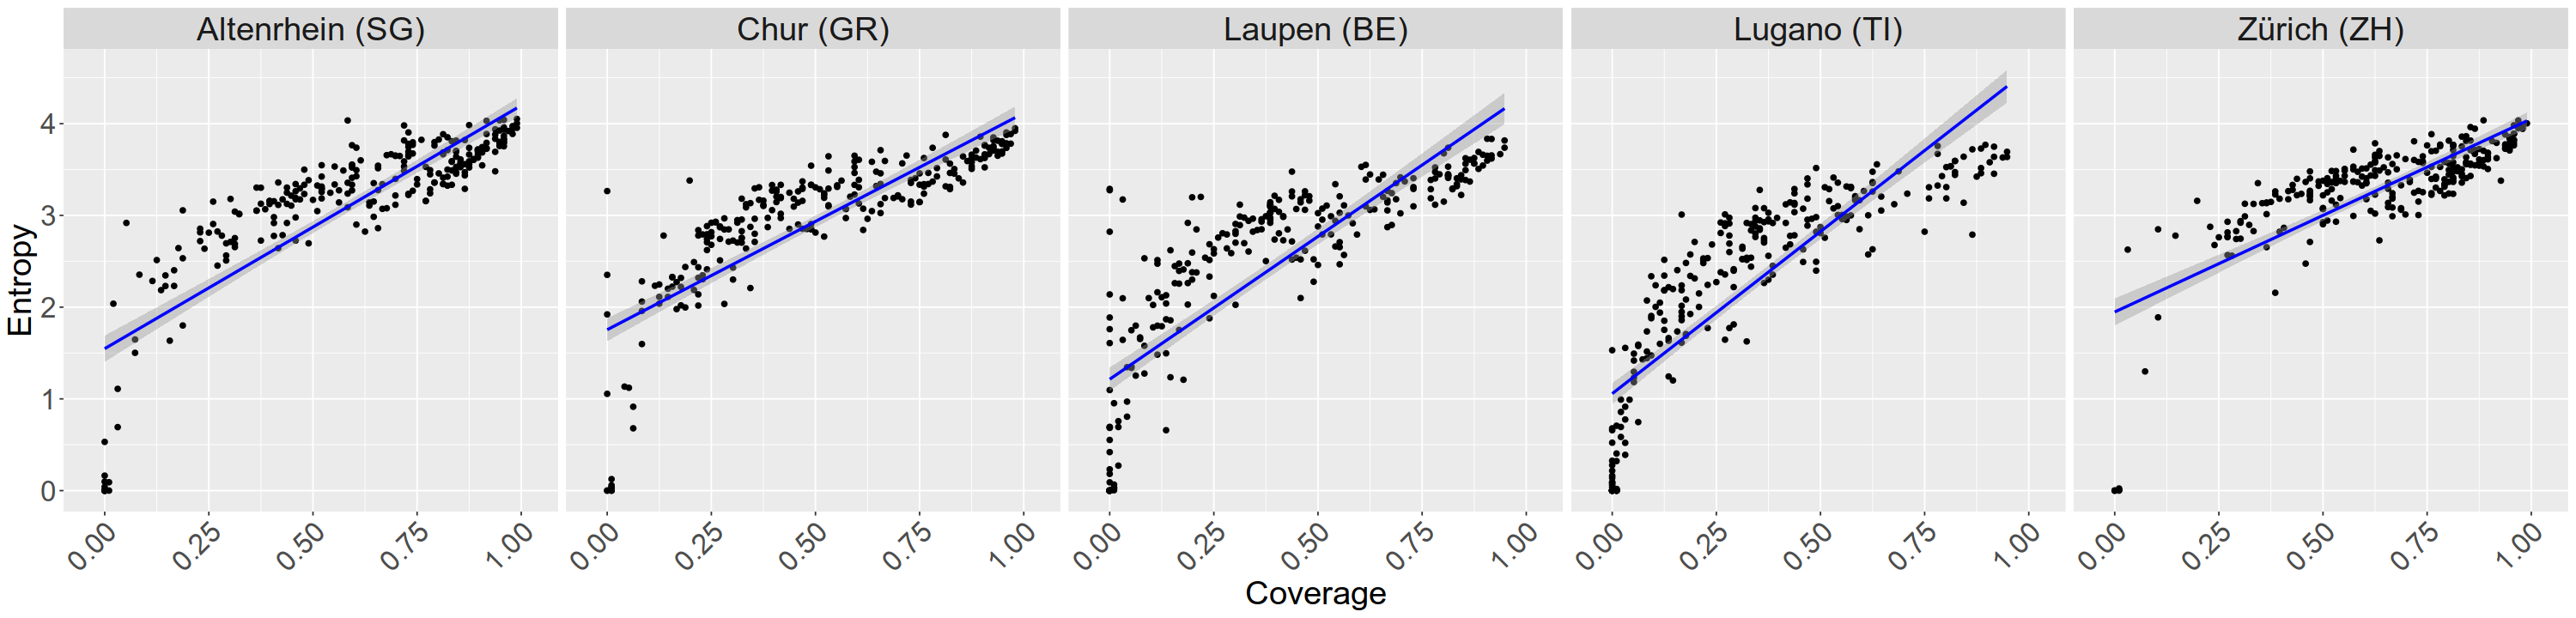

In [25]:
options(repr.plot.width=25, repr.plot.height=6)
number=20
coverage_entropy_together %>%  ggplot(aes(coverage, entropy)) + geom_point() + facet_wrap(~location, ncol = num_locations) + 
                    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = number), axis.text.y = element_text(size = number), 
                  axis.title.x = element_text(size = 23), axis.title.y = element_text(size = 23),strip.text = element_text(size=23))+
                  xlab("Coverage") + ylab("Entropy") + geom_smooth(method="lm", col = "blue") +
                  scale_x_continuous(expand = expansion(mult = c(0.1, 0.1)))  # Add some space on the x-axis

ggsave("correlation_low.eps", path="FinalReport/figures", width = 16, height = 6)


### Coverage with color coded delay

In [26]:
#Define datatables coverage_model_threshold that contain both coverage and delay
dt_no_repetition <- dt %>% distinct(date, location, .keep_all = TRUE)
coverage_model_1000 <- merge(dt_no_repetition,coverage_threshold1000, by = c("date", "location"))
coverage_model_100 <-  merge(dt_no_repetition,coverage_threshold100, by = c("date", "location"))
coverage_model_200 <-  merge(dt_no_repetition,coverage_threshold200, by = c("date", "location"))


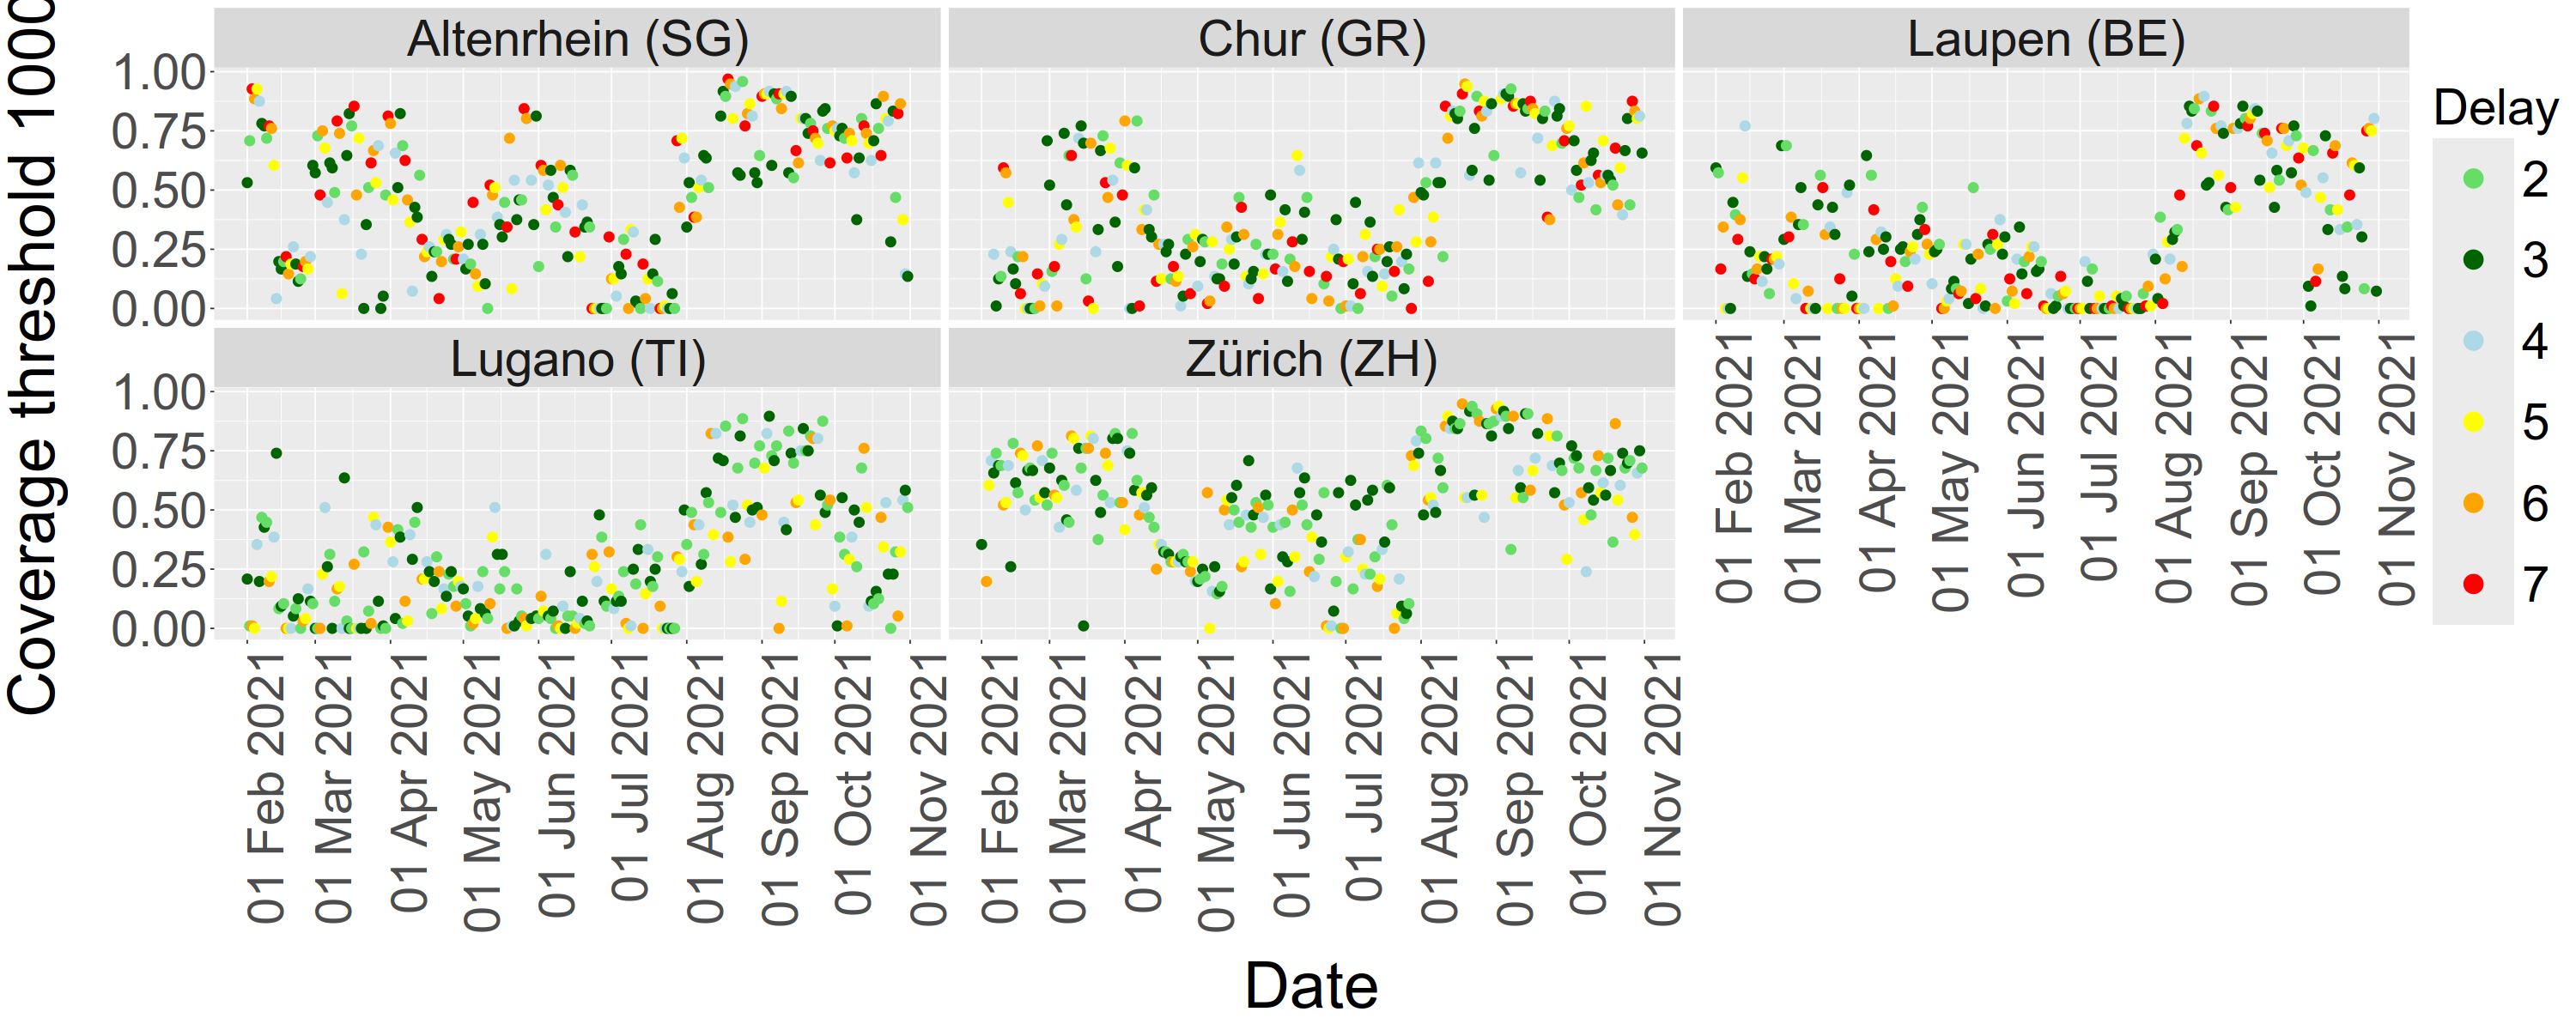

In [27]:
#plot of coverage with colored delays
options(repr.plot.width=25, repr.plot.height=10)
number=35
custom_colors <- c("2" = "#66DD66", "3" = "darkgreen" , "4" = "lightblue", "5" = "yellow" , "6"= "orange", "7" = "red")
coverage_model_1000 %>%  
    ggplot(aes(date, coverage, color = factor(delay))) + geom_point(size=3) + facet_wrap(~location) + 
    scale_color_manual(name = "Delay", values = custom_colors) + labs(x="Date", y= "Coverage threshold 1000") +
    scale_x_date(date_labels = "%d %b %Y",date_breaks = "1.5 month") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = number), axis.text.y = element_text(size = number), 
          axis.title.x = element_text(size = number+10,margin = margin(t=20)), axis.title.y = element_text(size = number+10, margin = margin(r=30)),
          strip.text = element_text(size = number), legend.text = element_text(size = number),
         legend.title = element_text(size=number), legend.key.size = unit(2.5, "cm"), legend.key.height = unit(2, "cm"),
          legend.key.width = unit(2, "cm")) +
     guides(color = guide_legend(override.aes = list(size = 6))) 

ggsave("low_coverage_delay_colors.eps", path="FinalReport/figures", width = 25, height=15)



# Spectral Density


In [28]:
find_psd_by_location_entropy <- function(ww_data) {
  psdframe <- data.table()

  #for each location we calculate the spectral density
  for (ara in unique(ww_data$location)) {
    values <- ww_data[ww_data$location == ara,]$entropy
      
    # Compute Periodogram using the stats package
    spec <- spectrum(values, plot = FALSE)
    
    frequency <- spec$freq
    psd <- spec$spec
    
    araframe <- data.table(
      frequency = frequency, 
      PSD = psd, 
      WWTP = ara
    )
    psdframe <- rbind(psdframe, araframe)
  }

  #plot the resulting graph
  number = 20
  psd_plot <- ggplot() + 
    geom_line(data = psdframe, aes(x = 1 / frequency, y = PSD, color = WWTP)) + 
    xlab('Period (days)') +
    xlim(c(2, 9)) +
    ylim(c(0,5))+
    facet_wrap(~ WWTP)+
    theme(axis.text.x=element_text(size=number), axis.text.y = element_text(size = number), 
    axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),
    strip.text = element_text(size = number),legend.position = "none")
  
  
    print(psd_plot)
    
  return(psdframe)
}

#___________________________________________________________________________________________
find_psd_by_location_coverage <- function(ww_data) {
  psdframe <- data.table()

  #for each location we calculate the spectral density
  for (ara in unique(ww_data$location)) {
    values <- ww_data[ww_data$location == ara,]$coverage
      
    # Compute Periodogram using the stats package
    spec <- spectrum(values, plot = FALSE)
    
    frequency <- spec$freq
    psd <- spec$spec
    
    araframe <- data.table(
      frequency = frequency, 
      PSD = psd, 
      WWTP = ara
    )
    psdframe <- rbind(psdframe, araframe)
  }

  #plot the resulting graph
  number=23
  psd_plot <- ggplot() + 
    geom_line(data = psdframe, aes(x = 1 / frequency, y = PSD, color = WWTP)) + 
    xlab('Period (days)') +
    xlim(c(2, 9)) +
    ylim(c(0,5))+
    facet_wrap(~ WWTP)+
    theme(axis.text.x=element_text(size=number), axis.text.y = element_text(size = number), 
    axis.title.x = element_text(size = number), axis.title.y = element_text(size = number),
    strip.text = element_text(size = number),legend.position = "none")  
    print(psd_plot)
    
  return(psdframe)
}



Warning message:
“Removed 147 rows containing missing values or values outside the scale range (`geom_line()`).”

frequency   PSD          WWTP           
1   0.003703704 1.8827280403 Altenrhein (SG)
2   0.007407407 2.0245836700 Altenrhein (SG)
3   0.011111111 1.5604295220 Altenrhein (SG)
4   0.014814815 1.2067550387 Altenrhein (SG)
5   0.018518519 0.1017768912 Altenrhein (SG)
6   0.022222222 0.0051812006 Altenrhein (SG)
7   0.025925926 0.1441888086 Altenrhein (SG)
8   0.029629630 0.0197298122 Altenrhein (SG)
9   0.033333333 0.4038859411 Altenrhein (SG)
10  0.037037037 0.0006131165 Altenrhein (SG)
11  0.040740741 0.2043260864 Altenrhein (SG)
12  0.044444444 0.0255734814 Altenrhein (SG)
13  0.048148148 0.0507310820 Altenrhein (SG)
14  0.051851852 0.0086624224 Altenrhein (SG)
15  0.055555556 0.0690101259 Altenrhein (SG)
16  0.059259259 0.0064051757 Altenrhein (SG)
17  0.062962963 0.0078643001 Altenrhein (SG)
18  0.066666667 0.1426173485 Altenrhein (SG)
19  0.070370370 0.0148302516 Altenrhein (SG)
20  0.074074074 0.0044538191 Altenrhein (SG)
21  0.077777778 0.0120478547 Altenrhein (SG)
22  0.081481481 0.1275086871 Altenrhein (SG)
23  0.085185185 0.0226285136 Altenrhein (SG)
24  0.088888889 0.0341443745 Altenrhein (SG)
25  0.092592593 0.0900052245 Altenrhein (SG)
26  0.096296296 0.1321021425 Altenrhein (SG)
27  0.100000000 0.0023024140 Altenrhein (SG)
28  0.103703704 0.0294224077 Altenrhein (SG)
29  0.107407407 0.0823179896 Altenrhein (SG)
30  0.111111111 0.0036666828 Altenrhein (SG)
... ...         ...          ...            
655 0.3925926   0.0255991466 Zürich (ZH)    
656 0.3962963   0.0180566086 Zürich (ZH)    
657 0.4000000   0.0231153858 Zürich (ZH)    
658 0.4037037   0.0648791428 Zürich (ZH)    
659 0.4074074   0.0239409195 Zürich (ZH)    
660 0.4111111   0.0055688850 Zürich (ZH)    
661 0.4148148   0.0150462922 Zürich (ZH)    
662 0.4185185   0.0142824650 Zürich (ZH)    
663 0.4222222   0.0202656709 Zürich (ZH)    
664 0.4259259   0.0037543008 Zürich (ZH)    
665 0.4296296   0.0096089727 Zürich (ZH)    
666 0.4333333   0.0093688150 Zürich (ZH)    
667 0.4370370   0.0101099461 Zürich (ZH)    
668 0.4407407   0.0317014587 Zürich (ZH)    
669 0.4444444   0.0534755672 Zürich (ZH)    
670 0.4481481   0.0420645064 Zürich (ZH)    
671 0.4518519   0.0056339996 Zürich (ZH)    
672 0.4555556   0.0022006022 Zürich (ZH)    
673 0.4592593   0.0364459622 Zürich (ZH)    
674 0.4629630   0.0005465283 Zürich (ZH)    
675 0.4666667   0.0115041537 Zürich (ZH)    
676 0.4703704   0.0154582001 Zürich (ZH)    
677 0.4740741   0.0068942537 Zürich (ZH)    
678 0.4777778   0.0314512816 Zürich (ZH)    
679 0.4814815   0.0031506522 Zürich (ZH)    
680 0.4851852   0.0705408371 Zürich (ZH)    
681 0.4888889   0.0048010947 Zürich (ZH)    
682 0.4925926   0.0098548128 Zürich (ZH)    
683 0.4962963   0.0024175788 Zürich (ZH)    
684 0.5000000   0.0283728754 Zürich (ZH)

Warning message:
“Removed 147 rows containing missing values or values outside the scale range (`geom_line()`).”

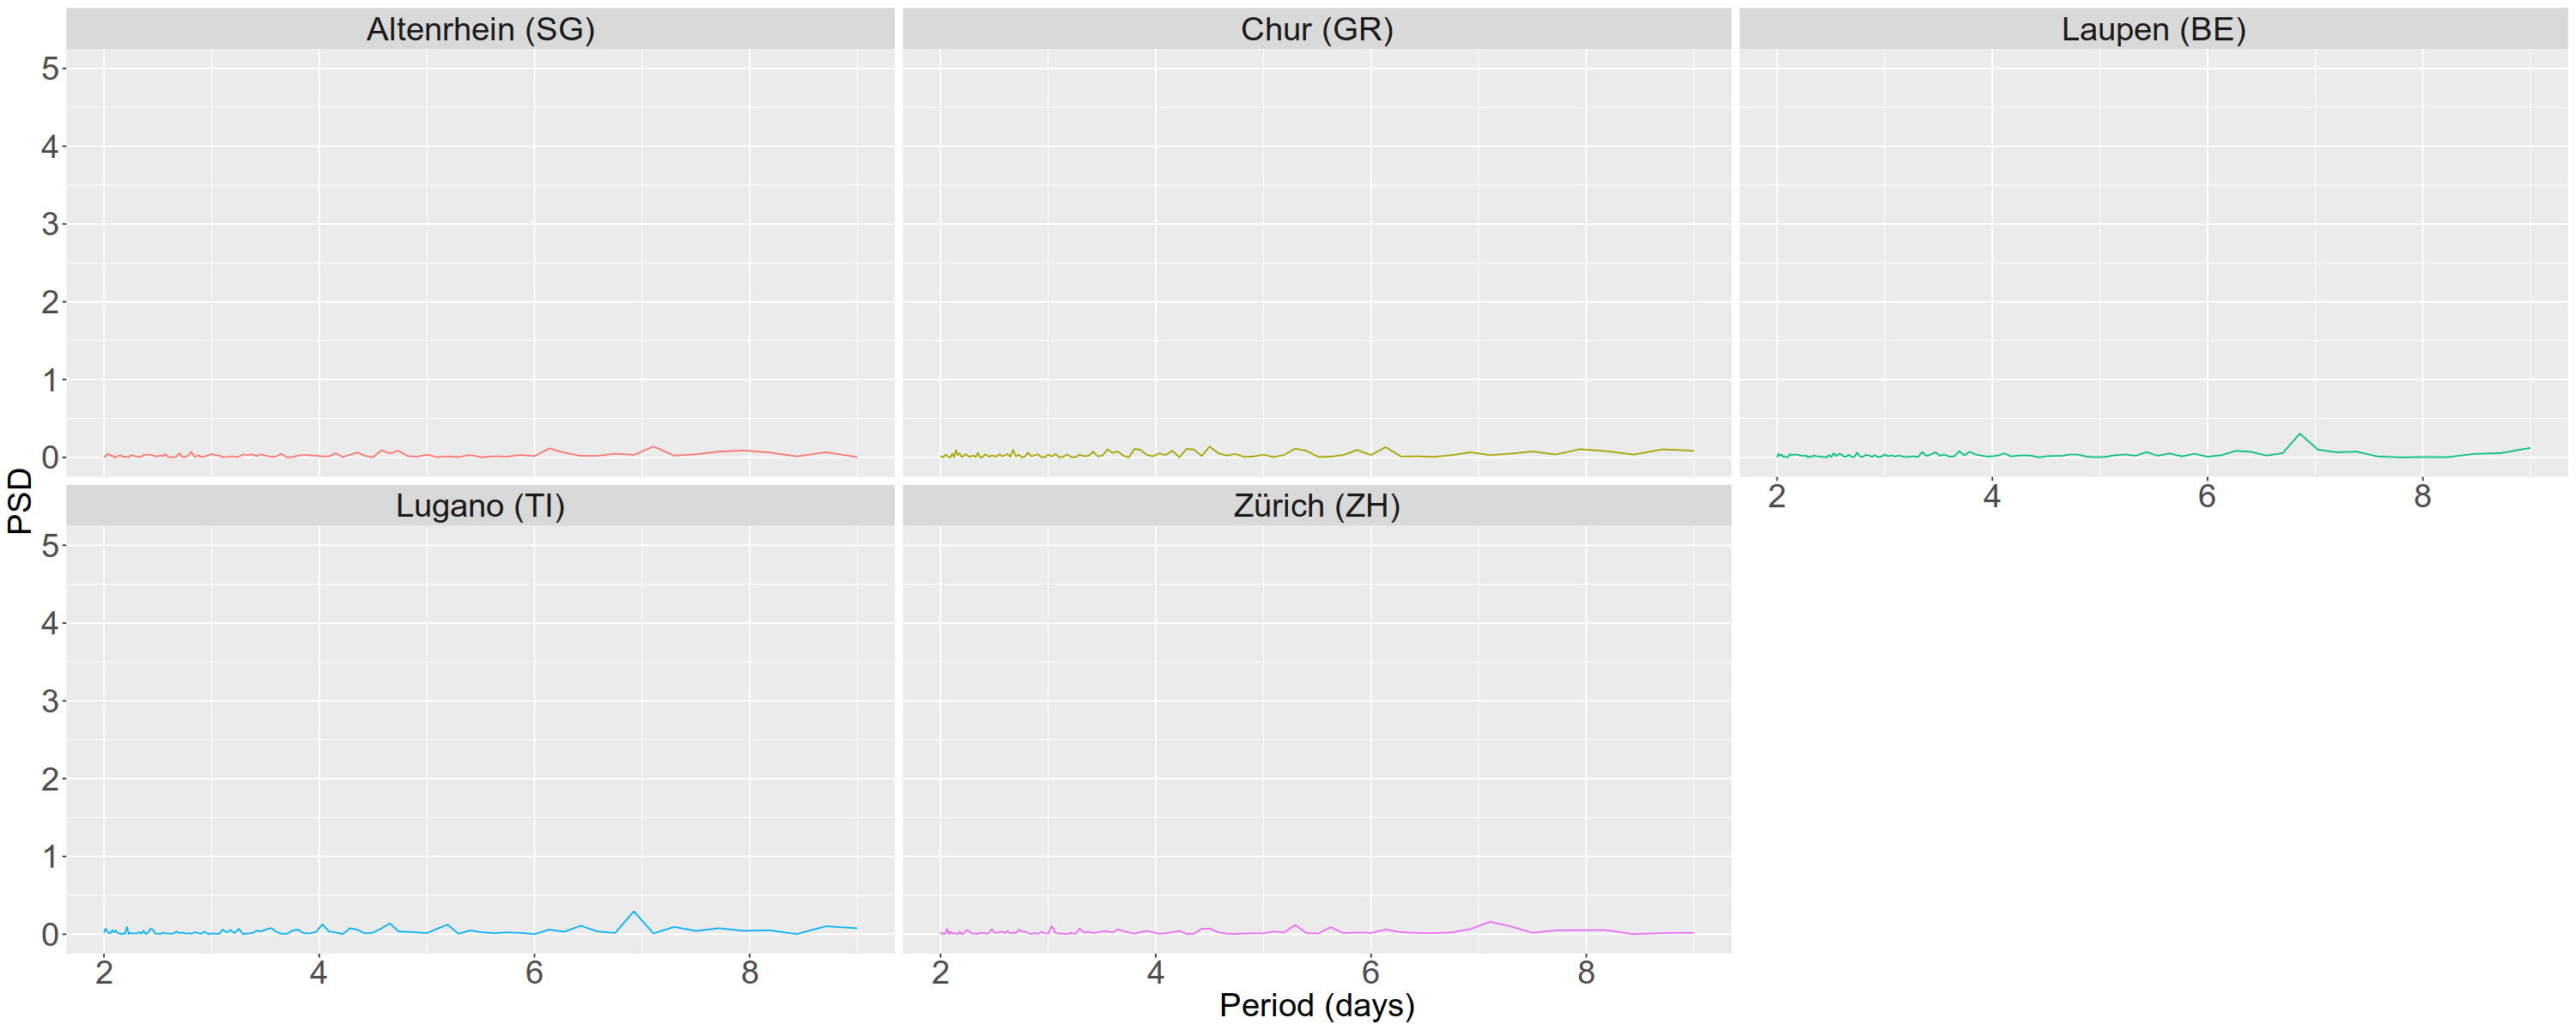

In [29]:
find_psd_by_location_coverage(coverage_threshold100)
ggsave("period_coverage_low.eps", path="FinalReport/figures", width =12, height = 5)


Warning message:
“Removed 147 rows containing missing values or values outside the scale range (`geom_line()`).”

frequency   PSD         WWTP           
1   0.003703704  9.4618804  Altenrhein (SG)
2   0.007407407 25.0865433  Altenrhein (SG)
3   0.011111111 15.6219146  Altenrhein (SG)
4   0.014814815  7.9563598  Altenrhein (SG)
5   0.018518519  1.7146132  Altenrhein (SG)
6   0.022222222  0.2646028  Altenrhein (SG)
7   0.025925926  1.9438301  Altenrhein (SG)
8   0.029629630  0.5771383  Altenrhein (SG)
9   0.033333333  5.9480729  Altenrhein (SG)
10  0.037037037  1.8858525  Altenrhein (SG)
11  0.040740741  1.9535933  Altenrhein (SG)
12  0.044444444  1.5416321  Altenrhein (SG)
13  0.048148148  1.2384122  Altenrhein (SG)
14  0.051851852  0.1008903  Altenrhein (SG)
15  0.055555556  0.8021127  Altenrhein (SG)
16  0.059259259  0.9771356  Altenrhein (SG)
17  0.062962963  1.2183245  Altenrhein (SG)
18  0.066666667  2.8857290  Altenrhein (SG)
19  0.070370370  1.2331443  Altenrhein (SG)
20  0.074074074  0.7179905  Altenrhein (SG)
21  0.077777778  1.0539743  Altenrhein (SG)
22  0.081481481  0.8552262  Altenrhein (SG)
23  0.085185185  0.1800025  Altenrhein (SG)
24  0.088888889  0.1803230  Altenrhein (SG)
25  0.092592593  0.5322430  Altenrhein (SG)
26  0.096296296  0.7727347  Altenrhein (SG)
27  0.100000000  0.2748781  Altenrhein (SG)
28  0.103703704  0.6529259  Altenrhein (SG)
29  0.107407407  0.7243150  Altenrhein (SG)
30  0.111111111  0.2860759  Altenrhein (SG)
... ...         ...         ...            
655 0.3925926   0.239795722 Zürich (ZH)    
656 0.3962963   0.220432693 Zürich (ZH)    
657 0.4000000   0.076408602 Zürich (ZH)    
658 0.4037037   0.236123387 Zürich (ZH)    
659 0.4074074   0.085214816 Zürich (ZH)    
660 0.4111111   0.063476060 Zürich (ZH)    
661 0.4148148   0.228268494 Zürich (ZH)    
662 0.4185185   0.155319092 Zürich (ZH)    
663 0.4222222   0.285608235 Zürich (ZH)    
664 0.4259259   0.032992962 Zürich (ZH)    
665 0.4296296   0.102758820 Zürich (ZH)    
666 0.4333333   0.085197952 Zürich (ZH)    
667 0.4370370   0.124732980 Zürich (ZH)    
668 0.4407407   0.212839163 Zürich (ZH)    
669 0.4444444   0.218051956 Zürich (ZH)    
670 0.4481481   0.213697148 Zürich (ZH)    
671 0.4518519   0.222406613 Zürich (ZH)    
672 0.4555556   0.038678756 Zürich (ZH)    
673 0.4592593   0.647298540 Zürich (ZH)    
674 0.4629630   0.101109460 Zürich (ZH)    
675 0.4666667   0.171299693 Zürich (ZH)    
676 0.4703704   0.398657406 Zürich (ZH)    
677 0.4740741   0.120881281 Zürich (ZH)    
678 0.4777778   0.284776379 Zürich (ZH)    
679 0.4814815   0.009065258 Zürich (ZH)    
680 0.4851852   0.491792518 Zürich (ZH)    
681 0.4888889   0.066820136 Zürich (ZH)    
682 0.4925926   0.161291513 Zürich (ZH)    
683 0.4962963   0.040526973 Zürich (ZH)    
684 0.5000000   0.260059314 Zürich (ZH)

Warning message:
“Removed 147 rows containing missing values or values outside the scale range (`geom_line()`).”

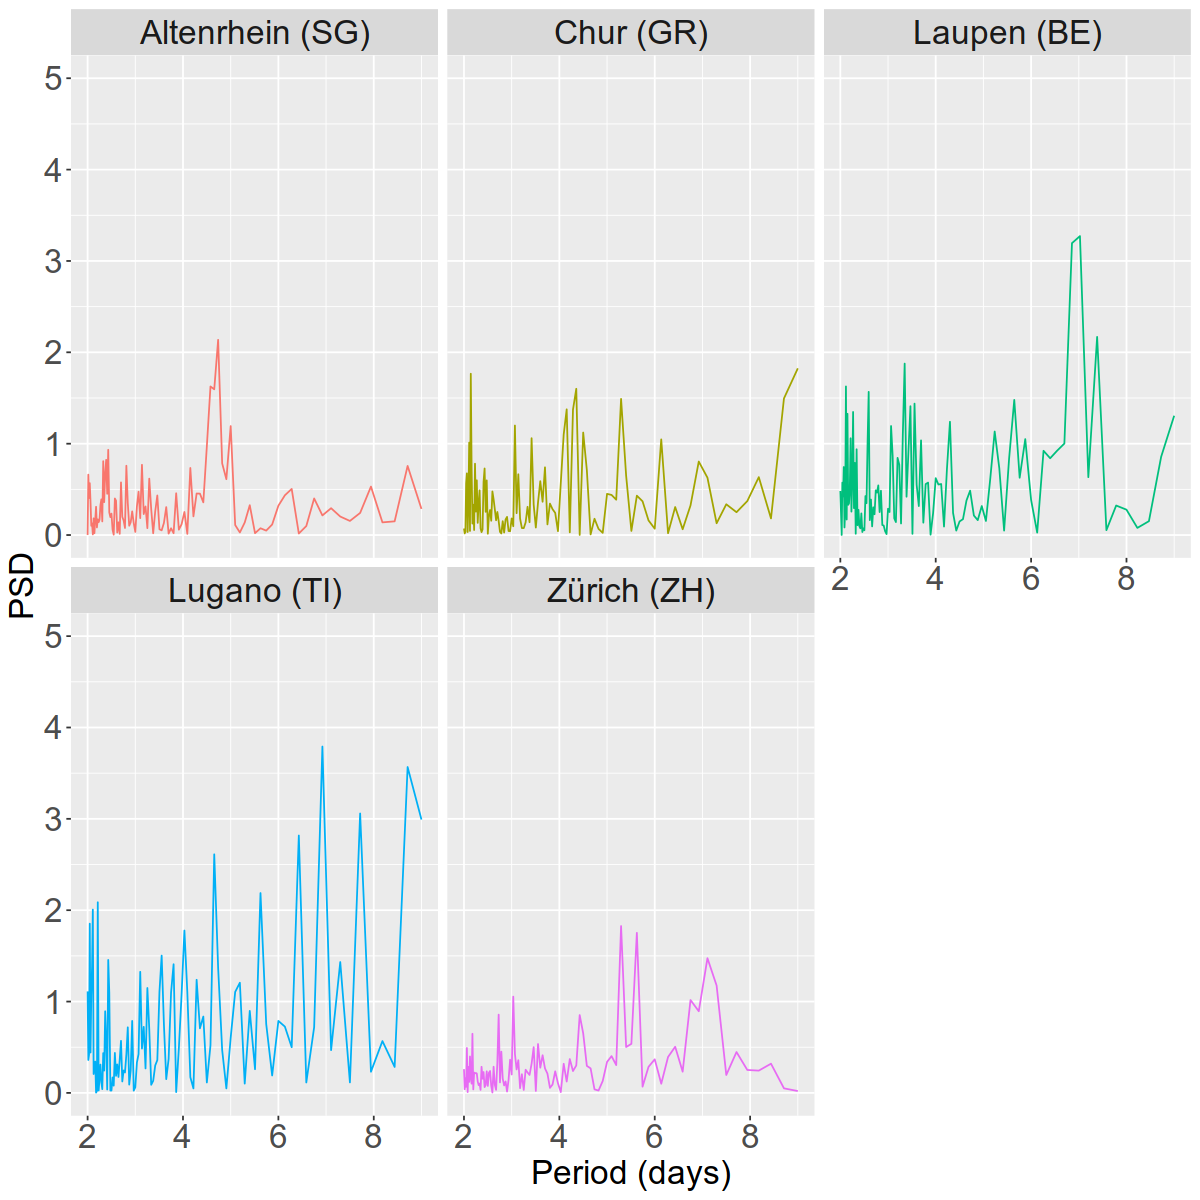

In [30]:
options(repr.plot.width=10, repr.plot.height=10)

find_psd_by_location_entropy(sum_entropy_psd)
ggsave("period_low.eps", path="FinalReport/figures", width =12, height = 5)



# Regression: multivariate model
Let us first define the necessary data tables

In [31]:
#datatable with sequencing device, concentration, entropy, delay and running average
model_entropy_concentration <- merge(sum_entropy_distinct,dt_viral, by = c("date", "location"))

#now let us separate this datatable according to locations
model_entropy_concentration_chur <- model_entropy_concentration %>% filter(location == 'Chur (GR)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 7, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_entropy_concentration_lugano <- model_entropy_concentration %>% filter(location == 'Lugano (TI)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 6, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_entropy_concentration_altenrhein <- model_entropy_concentration %>% filter(location == 'Altenrhein (SG)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 7, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_entropy_concentration_laupen <- model_entropy_concentration %>% filter(location == 'Laupen (BE)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 7, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_entropy_concentration_zurich <- model_entropy_concentration %>% filter(location == 'Zürich (ZH)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 6, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))


#create data table that combines coverage_100, delay, sequencing device and concentrations
model_coverage_100_concentration <- merge(coverage_model_100,dt_viral, by = c("date", "location"))

#separate this datatable according to locations
model_coverage_100_concentration_chur <- model_coverage_100_concentration %>% filter(location == 'Chur (GR)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 7, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_coverage_100_concentration_lugano <- model_coverage_100_concentration %>% filter(location == 'Lugano (TI)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 6, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_coverage_100_concentration_altenrhein <- model_coverage_100_concentration %>% filter(location == 'Altenrhein (SG)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 7, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_coverage_100_concentration_laupen <- model_coverage_100_concentration %>% filter(location == 'Laupen (BE)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 7, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

model_coverage_100_concentration_zurich <- model_coverage_100_concentration %>% filter(location == 'Zürich (ZH)')%>%
  arrange(date) %>% mutate(running_average = rollapply(concentration_mean, width = 6, 
                FUN = mean, fill = NA, align = 'right'))  %>%
                mutate(running_average = if_else(is.na(running_average), concentration_mean, running_average))

tail(model_entropy_concentration_chur)

date       location  batch              amplicon depth    sample_day
233 2021-10-26 Chur (GR) 20211105_HML7HDRXY X0          106.0 2         
234 2021-10-27 Chur (GR) 20211112_HN3JWDRXY X0       192441.0 3         
235 2021-10-28 Chur (GR) 20211112_HN3JWDRXY X0       338668.0 4         
236 2021-10-29 Chur (GR) 20211112_HN3JWDRXY X0       281270.5 5         
237 2021-10-30 Chur (GR) 20211112_HN3JWDRXY X0       233423.5 6         
238 2021-10-31 Chur (GR) 20211112_HN3JWDRXY X0       202844.5 7         
    test_day delay sequencing_device sequencing1 sequencing2 sequencing3
233 3        2     B                 0           1           0          
234 3        7     B                 0           1           0          
235 3        6     B                 0           1           0          
236 3        5     B                 0           1           0          
237 3        4     B                 0           1           0          
238 3        3     B                 0           1           0          
    sum      sum_norm     product      entropy  target  concentration_mean
233  2811953 3.769622e-05 0.0003839718 2.847413 SARS-N1 15.45212          
234  8342286 2.306814e-02 0.0869507946 3.742424 SARS-N1 51.47480          
235 10777692 3.142305e-02 0.1087304747 3.612981 SARS-N1 83.43005          
236  9393522 2.994303e-02 0.1050538852 3.619308 SARS-N1 94.22575          
237 11350860 2.056439e-02 0.0798760842 3.403698 SARS-N1 83.09114          
238  9193854 2.206305e-02 0.0841451944 3.146045 SARS-N1 79.78831          
    running_average
233 23.63950       
234 28.05572       
235 36.02884       
236 46.22529       
237 56.15515       
238 63.79887


Call:
lm(formula = entropy ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_chur)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1808 -0.2789  0.1657  0.5089  1.2380 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.930450   0.341878   8.572 1.43e-15 ***
delay            0.003249   0.030347   0.107   0.9148    
running_average  0.016040   0.002498   6.422 7.49e-10 ***
sequencing1     -0.411869   0.328000  -1.256   0.2105    
sequencing2     -0.596033   0.324198  -1.838   0.0673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7727 on 233 degrees of freedom
Multiple R-squared:  0.1656,	Adjusted R-squared:  0.1513 
F-statistic: 11.56 on 4 and 233 DF,  p-value: 1.402e-08


2.5 %       97.5 %    
(Intercept)      2.25688278 3.60401635
delay           -0.05654110 0.06304000
running_average  0.01111853 0.02096059
sequencing1     -1.05809412 0.23435662
sequencing2     -1.23476638 0.04270009


Call:
lm(formula = entropy ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_laupen)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7670 -0.5114  0.1993  0.6651  1.6103 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.814399   0.398810   7.057 1.54e-11 ***
delay           -0.087979   0.035844  -2.455   0.0148 *  
running_average  0.027709   0.005588   4.959 1.28e-06 ***
sequencing1     -0.817995   0.382420  -2.139   0.0334 *  
sequencing2     -0.254497   0.385423  -0.660   0.5096    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9715 on 260 degrees of freedom
Multiple R-squared:  0.2542,	Adjusted R-squared:  0.2427 
F-statistic: 22.15 on 4 and 260 DF,  p-value: 9.457e-16


2.5 %       97.5 %     
(Intercept)      2.02909056  3.59970735
delay           -0.15856054 -0.01739812
running_average  0.01670572  0.03871221
sequencing1     -1.57103076 -0.06495999
sequencing2     -1.01344485  0.50445054


Call:
lm(formula = entropy ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_zurich)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4289 -0.1668  0.0724  0.3689  0.8625 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.767486   0.260933  14.439  < 2e-16 ***
delay           -0.052371   0.028330  -1.849  0.06569 .  
running_average  0.004147   0.001274   3.256  0.00129 ** 
sequencing1     -0.578782   0.247532  -2.338  0.02017 *  
sequencing2     -0.438802   0.250752  -1.750  0.08135 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6324 on 250 degrees of freedom
Multiple R-squared:  0.104,	Adjusted R-squared:  0.08962 
F-statistic: 7.251 on 4 and 250 DF,  p-value: 1.539e-05


2.5 %        97.5 %      
(Intercept)      3.253579574  4.281392339
delay           -0.108167281  0.003424673
running_average  0.001638607  0.006655625
sequencing1     -1.066295806 -0.091268518
sequencing2     -0.932657506  0.055053614


Call:
lm(formula = entropy ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_altenrhein)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6454 -0.2258  0.1634  0.4635  1.3687 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.075388   0.350278   8.780 2.77e-16 ***
delay            0.049469   0.031645   1.563    0.119    
running_average  0.007771   0.001844   4.213 3.53e-05 ***
sequencing1     -0.805418   0.328884  -2.449    0.015 *  
sequencing2     -0.359987   0.325411  -1.106    0.270    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8362 on 247 degrees of freedom
Multiple R-squared:  0.1962,	Adjusted R-squared:  0.1831 
F-statistic: 15.07 on 4 and 247 DF,  p-value: 4.897e-11


2.5 %        97.5 %     
(Intercept)      2.385475327  3.76530027
delay           -0.012858867  0.11179665
running_average  0.004137946  0.01140314
sequencing1     -1.453193092 -0.15764220
sequencing2     -1.000920993  0.28094622


Call:
lm(formula = entropy ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_lugano)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5884 -0.6071  0.2912  0.7189  1.6184 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.342970   0.445018   7.512  1.6e-12 ***
delay           -0.014315   0.054810  -0.261  0.79422    
running_average -0.007040   0.004425  -1.591  0.11315    
sequencing1     -1.251318   0.421466  -2.969  0.00333 ** 
sequencing2     -0.688697   0.414220  -1.663  0.09786 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.054 on 212 degrees of freedom
Multiple R-squared:  0.06865,	Adjusted R-squared:  0.05107 
F-statistic: 3.906 on 4 and 212 DF,  p-value: 0.004406


2.5 %       97.5 %      
(Intercept)      2.46574174  4.220197582
delay           -0.12235782  0.093728465
running_average -0.01576348  0.001683669
sequencing1     -2.08211871 -0.420517013
sequencing2     -1.50521511  0.127821346

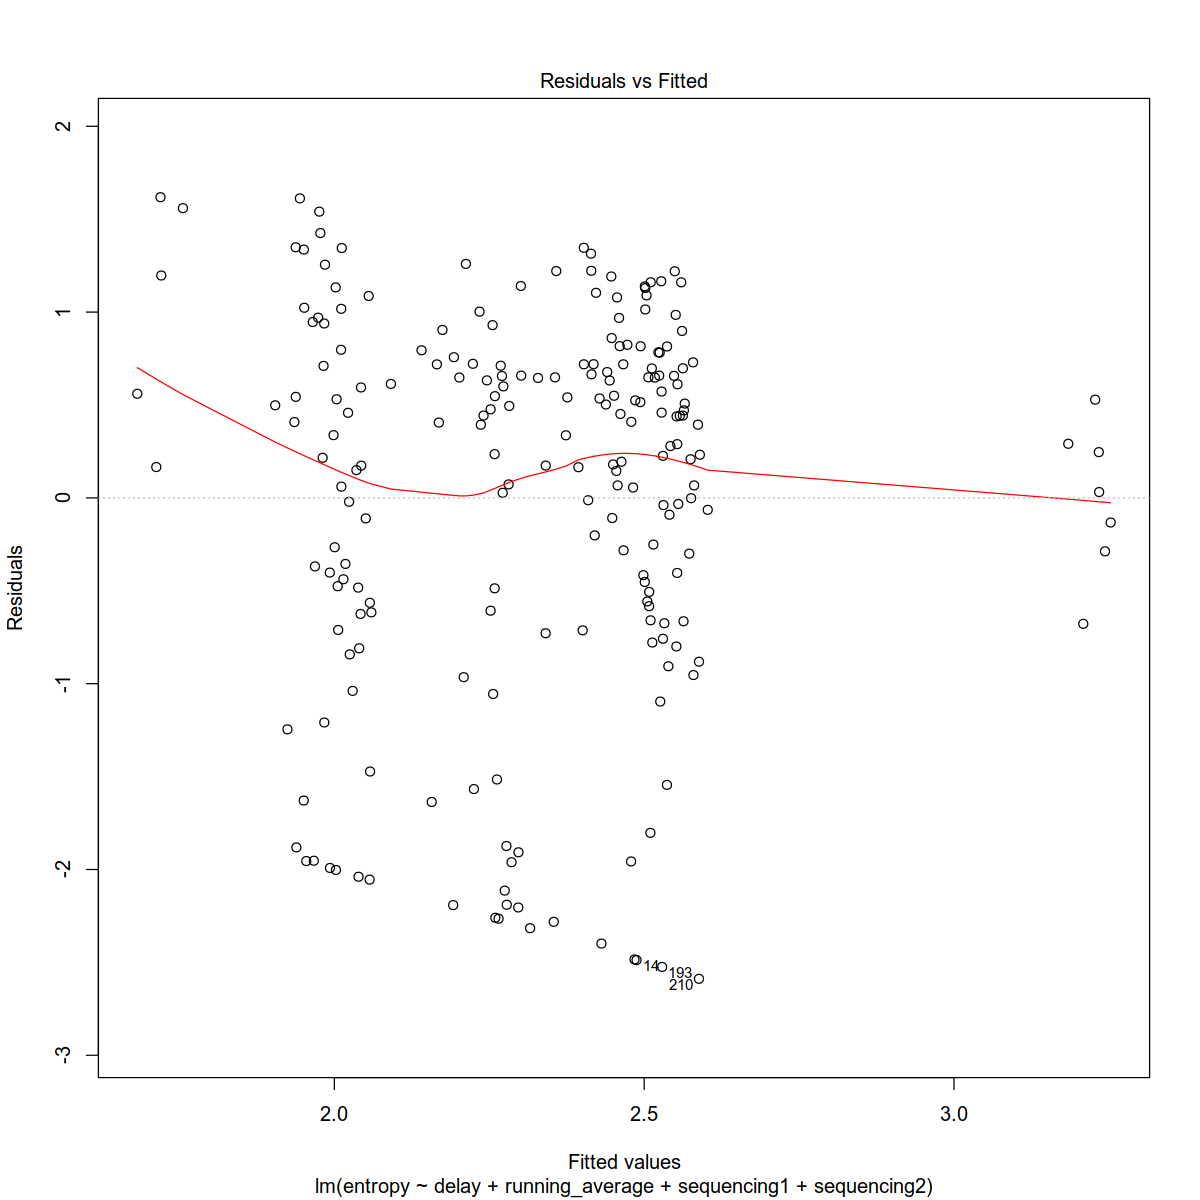

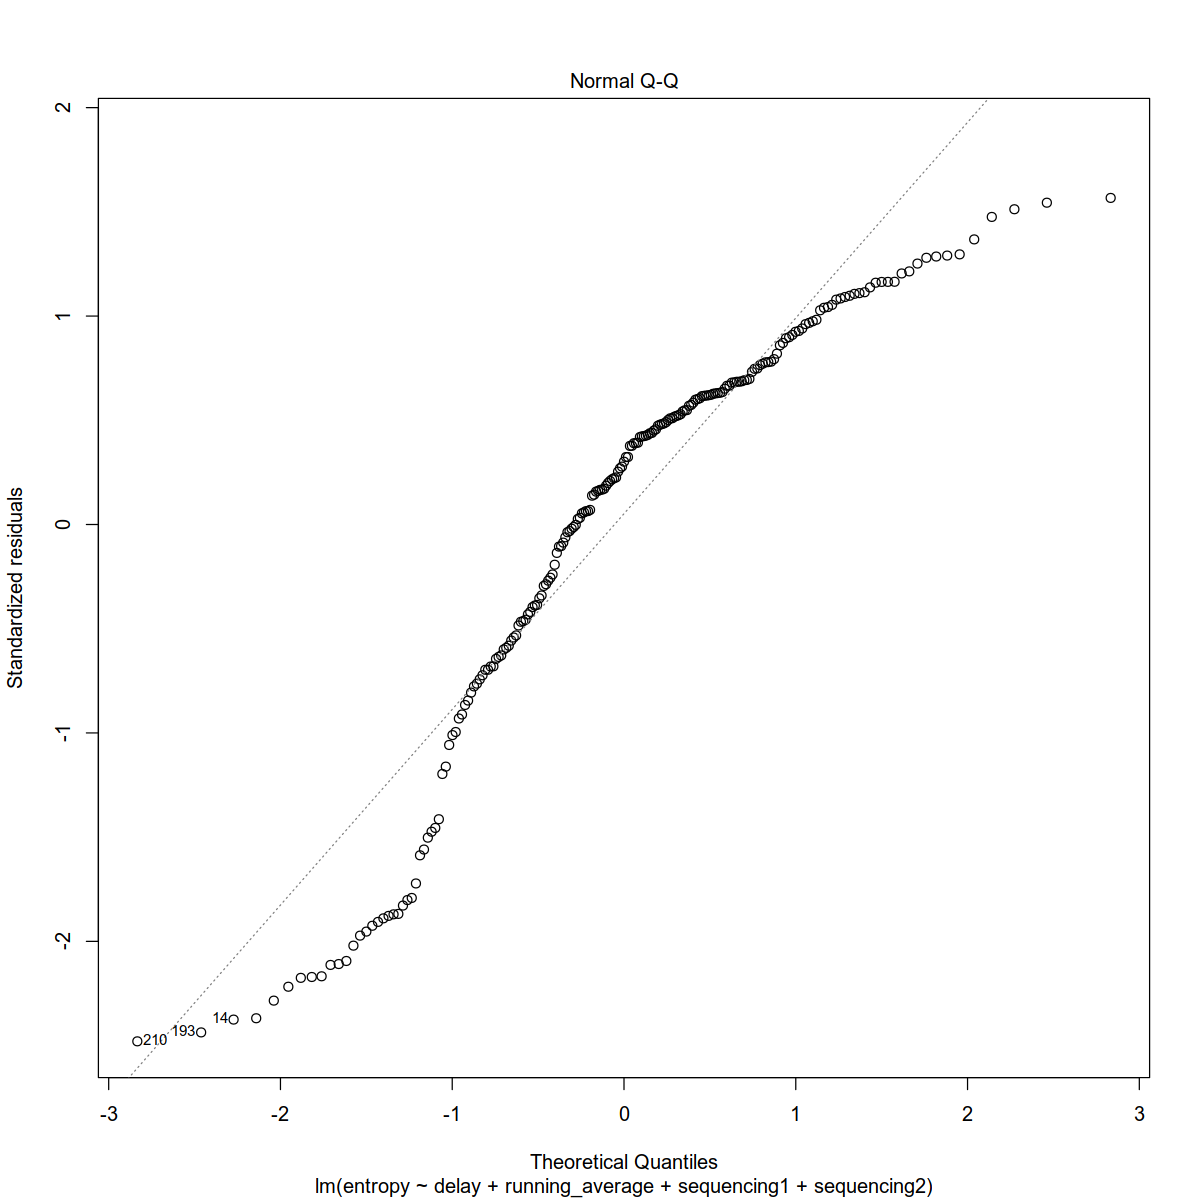

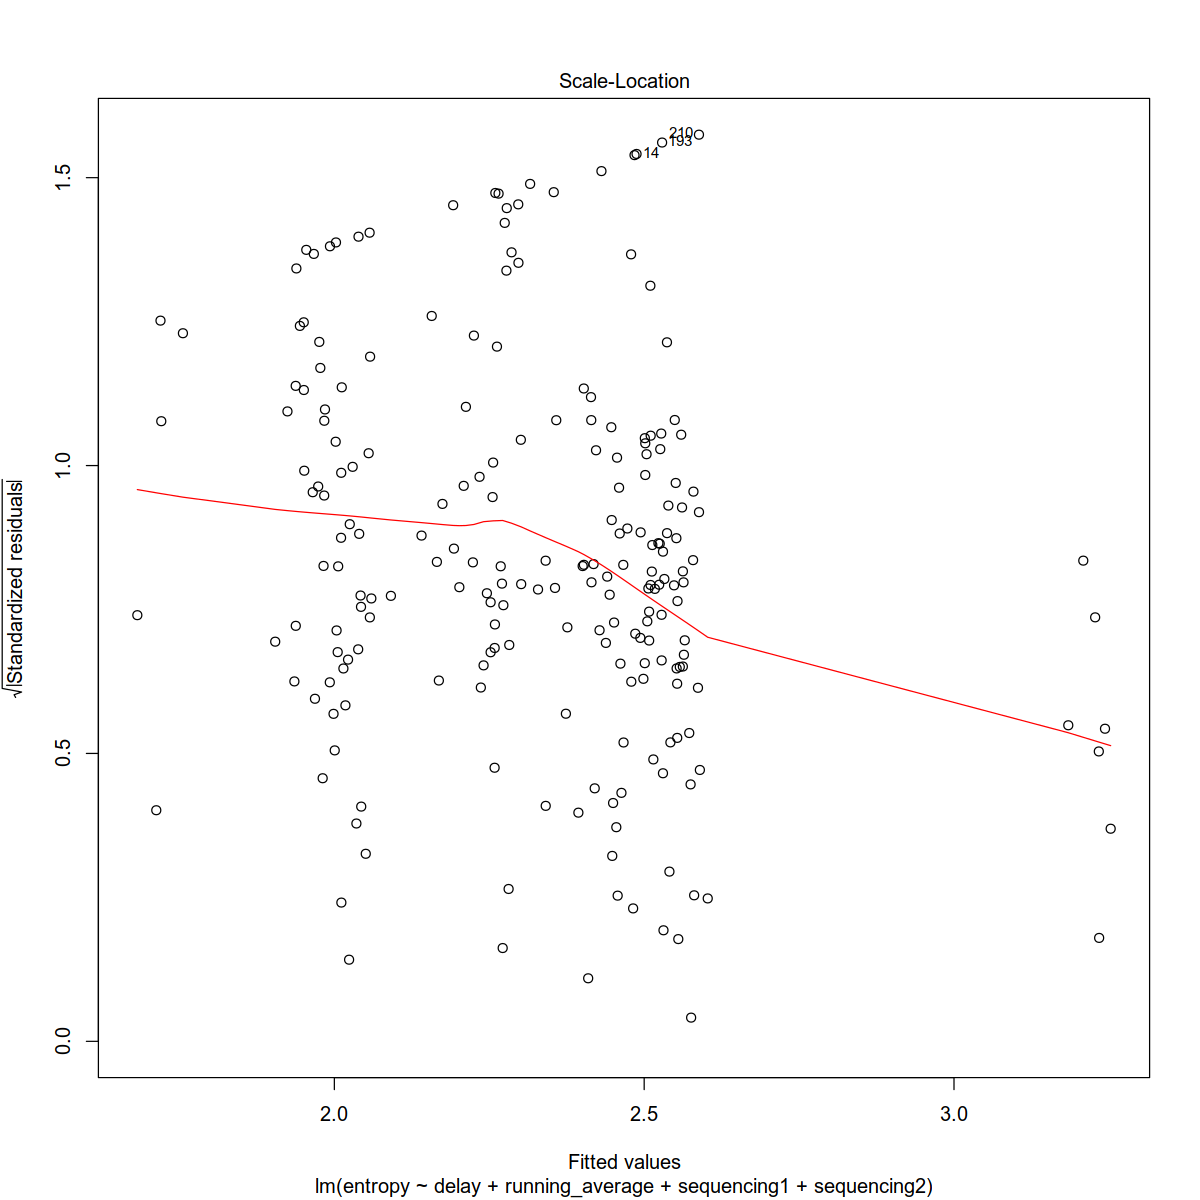

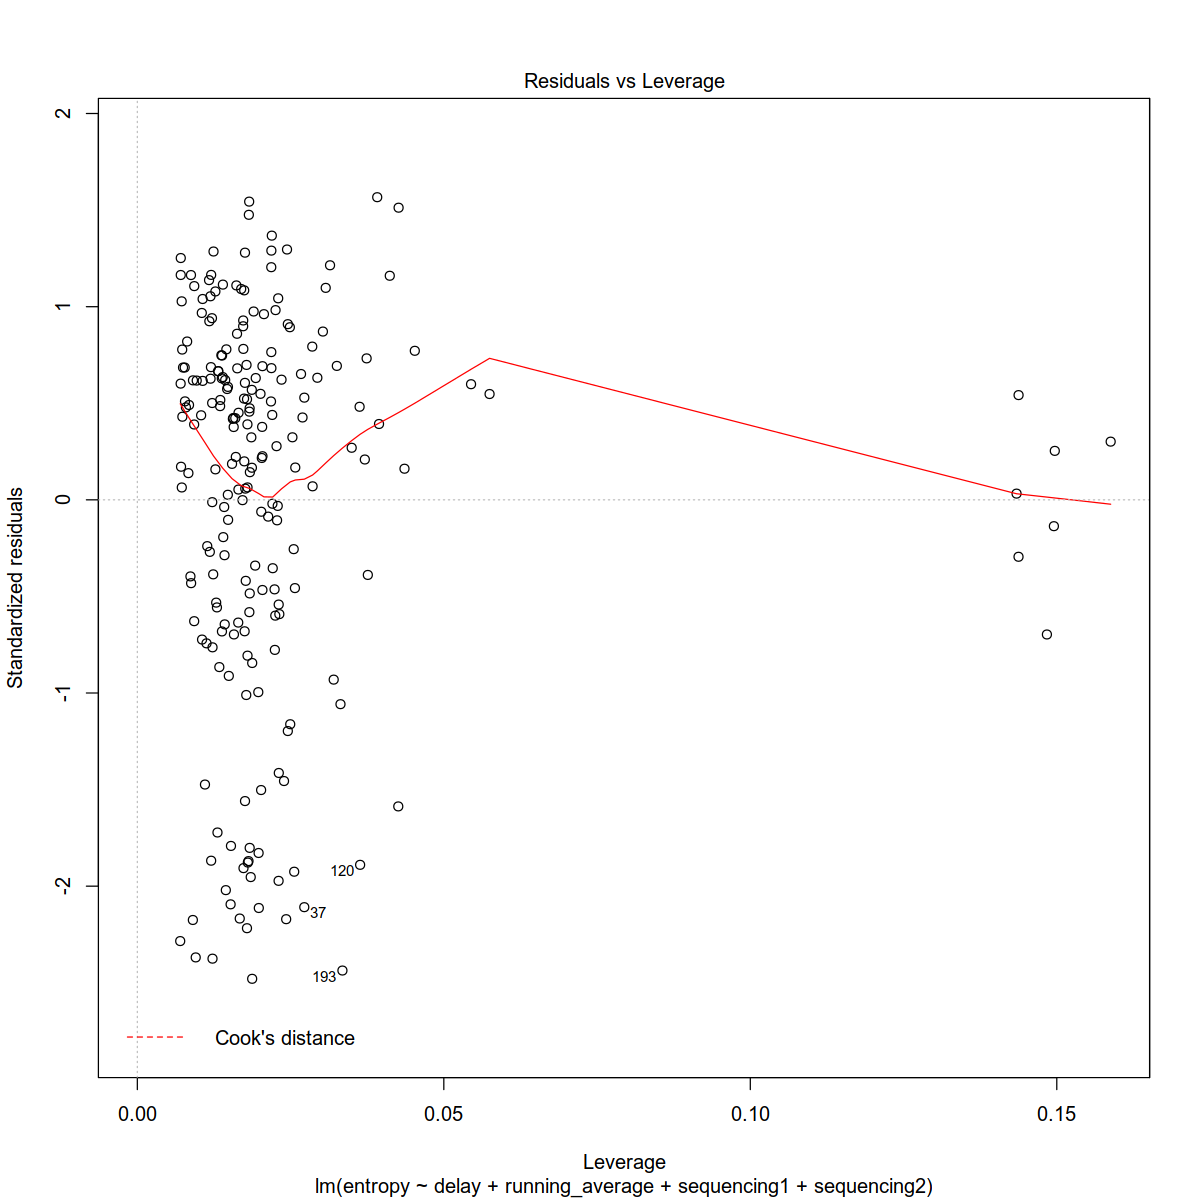

In [32]:
#fit entropy vs. predictors
lm_chur_multi_entropy <- lm(entropy ~ delay+running_average+sequencing1+sequencing2, data = model_entropy_concentration_chur)
summary(lm_chur_multi_entropy )
confint(lm_chur_multi_entropy )

lm_laupen_multi_entropy <- lm(entropy ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_laupen)
summary(lm_laupen_multi_entropy)
confint(lm_laupen_multi_entropy)

lm_zurich_multi_entropy <- lm(entropy ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_zurich)
summary(lm_zurich_multi_entropy)
confint(lm_zurich_multi_entropy)

lm_altenrhein_multi_entropy <- lm(entropy ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_altenrhein)
summary(lm_altenrhein_multi_entropy)
confint(lm_altenrhein_multi_entropy)

lm_lugano_multi_entropy <- lm(entropy ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_lugano)
summary(lm_lugano_multi_entropy)
confint(lm_lugano_multi_entropy)

# plot(lm_chur_multi_entropy)
# plot(lm_laupen_multi_entropy)
# plot(lm_zurich_multi_entropy)
# plot(lm_altenrhein_multi_entropy)
 plot(lm_lugano_multi_entropy)


Let us now take the exponential of entropy


Call:
lm(formula = exp(entropy) ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_chur)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.6765  -7.4248  -0.1495   7.7035  31.4339 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     23.14499    4.61449   5.016 1.05e-06 ***
delay            0.05976    0.40961   0.146   0.8841    
running_average  0.27257    0.03371   8.085 3.39e-14 ***
sequencing1     -8.34999    4.42718  -1.886   0.0605 .  
sequencing2     -8.87051    4.37585  -2.027   0.0438 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.43 on 233 degrees of freedom
Multiple R-squared:  0.2665,	Adjusted R-squared:  0.2539 
F-statistic: 21.16 on 4 and 233 DF,  p-value: 6.731e-15


2.5 %       97.5 %    
(Intercept)      14.0535306 32.2364521
delay            -0.7472620  0.8667826
running_average   0.2061475  0.3389905
sequencing1     -17.0724127  0.3724278
sequencing2     -17.4918035 -0.2492130


Call:
lm(formula = exp(entropy) ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_laupen)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.7340  -6.9396  -0.5979   6.1685  27.1291 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     18.26263    4.02672   4.535 8.79e-06 ***
delay           -0.76256    0.36191  -2.107   0.0361 *  
running_average  0.32170    0.05642   5.702 3.21e-08 ***
sequencing1     -6.34829    3.86124  -1.644   0.1014    
sequencing2     -1.10245    3.89156  -0.283   0.7772    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.809 on 260 degrees of freedom
Multiple R-squared:  0.2719,	Adjusted R-squared:  0.2607 
F-statistic: 24.28 on 4 and 260 DF,  p-value: < 2.2e-16


2.5 %       97.5 %     
(Intercept)      10.3334865 26.19177309
delay            -1.4752056 -0.04990935
running_average   0.2106064  0.43280265
sequencing1     -13.9515726  1.25500237
sequencing2      -8.7654345  6.56053178


Call:
lm(formula = exp(entropy) ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_zurich)

Residuals:
     Min       1Q   Median       3Q      Max 
-31.1970  -6.9947  -0.2826   7.3662  26.3598 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      39.32439    4.32533   9.092  < 2e-16 ***
delay            -0.52923    0.46961  -1.127  0.26084    
running_average   0.08972    0.02111   4.250 3.02e-05 ***
sequencing1     -11.74716    4.10319  -2.863  0.00455 ** 
sequencing2     -11.23832    4.15657  -2.704  0.00733 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.48 on 250 degrees of freedom
Multiple R-squared:  0.113,	Adjusted R-squared:  0.09884 
F-statistic: 7.965 on 4 and 250 DF,  p-value: 4.66e-06


2.5 %        97.5 %    
(Intercept)      30.80566229 47.8431267
delay            -1.45412700  0.3956690
running_average   0.04814184  0.1313061
sequencing1     -19.82839910 -3.6659293
sequencing2     -19.42468535 -3.0519630


Call:
lm(formula = exp(entropy) ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_altenrhein)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.387  -7.790  -0.042   9.271  32.819 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      26.57346    5.31371   5.001 1.08e-06 ***
delay             1.07897    0.48005   2.248   0.0255 *  
running_average   0.14019    0.02798   5.011 1.03e-06 ***
sequencing1     -10.38379    4.98917  -2.081   0.0384 *  
sequencing2      -7.52379    4.93647  -1.524   0.1288    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.69 on 247 degrees of freedom
Multiple R-squared:  0.1702,	Adjusted R-squared:  0.1568 
F-statistic: 12.67 on 4 and 247 DF,  p-value: 2.168e-09


2.5 %        97.5 %    
(Intercept)      16.10750180 37.0394111
delay             0.13346053  2.0244816
running_average   0.08508752  0.1953004
sequencing1     -20.21052269 -0.5570487
sequencing2     -17.24674015  2.1991528


Call:
lm(formula = exp(entropy) ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_entropy_concentration_lugano)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.5804  -8.8867  -0.7938   6.7918  25.5996 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      29.70304    4.53018   6.557 4.12e-10 ***
delay            -0.64038    0.55796  -1.148 0.252377    
running_average  -0.05677    0.04505  -1.260 0.208993    
sequencing1     -15.52230    4.29042  -3.618 0.000371 ***
sequencing2      -9.54170    4.21666  -2.263 0.024658 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.73 on 212 degrees of freedom
Multiple R-squared:  0.08855,	Adjusted R-squared:  0.07135 
F-statistic: 5.149 on 4 and 212 DF,  p-value: 0.0005602


2.5 %       97.5 %     
(Intercept)      20.7730739 38.63300059
delay            -1.7402309  0.45947411
running_average  -0.1455749  0.03203279
sequencing1     -23.9796482 -7.06495368
sequencing2     -17.8536551 -1.22974770

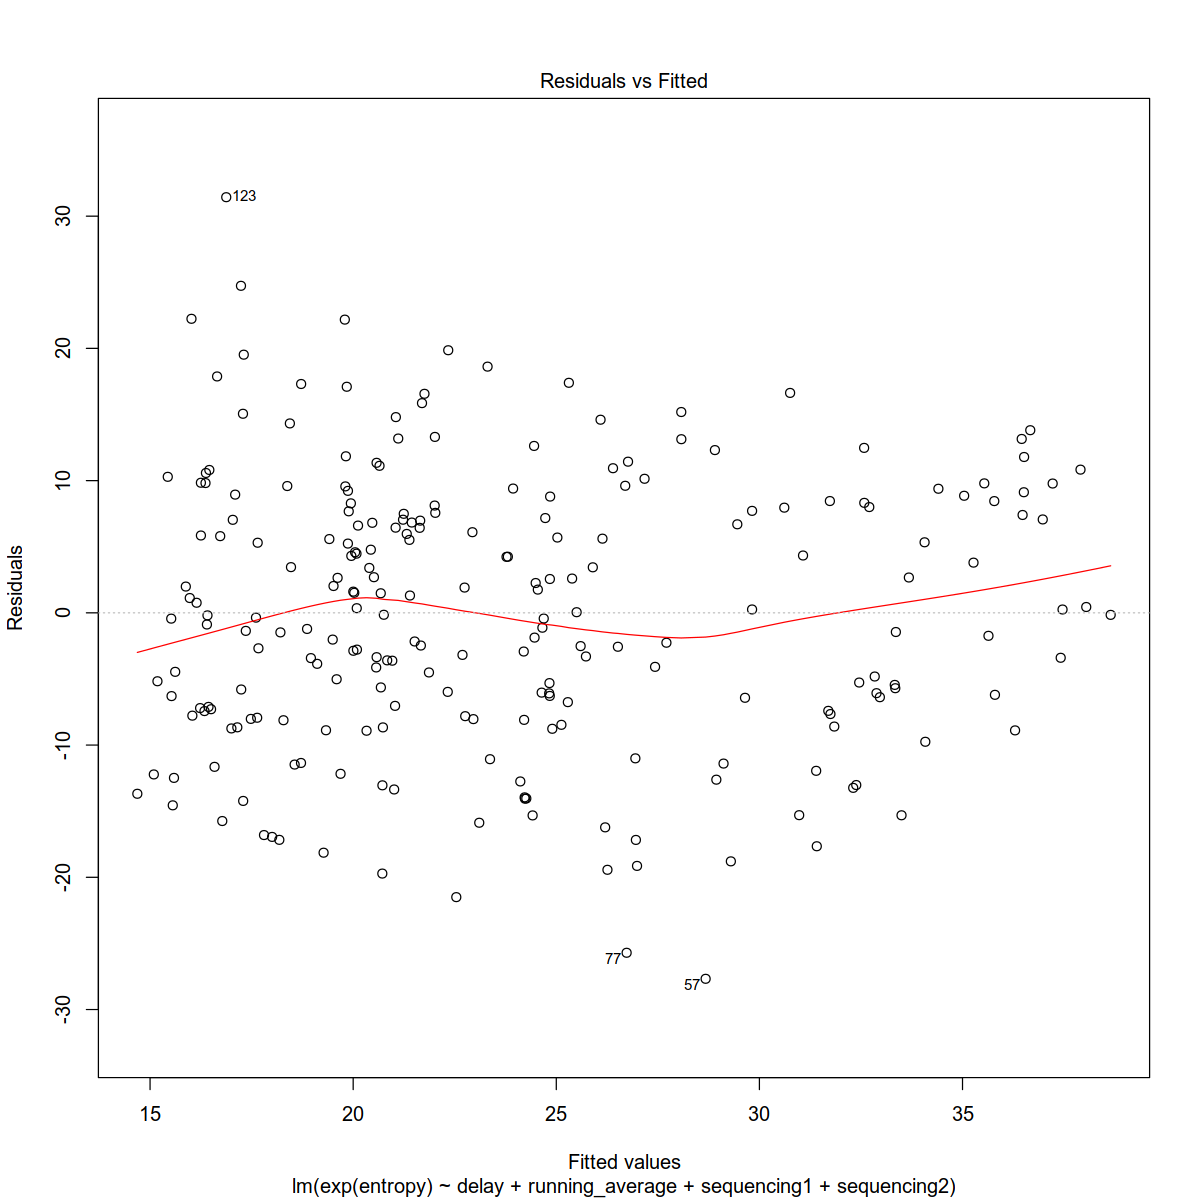

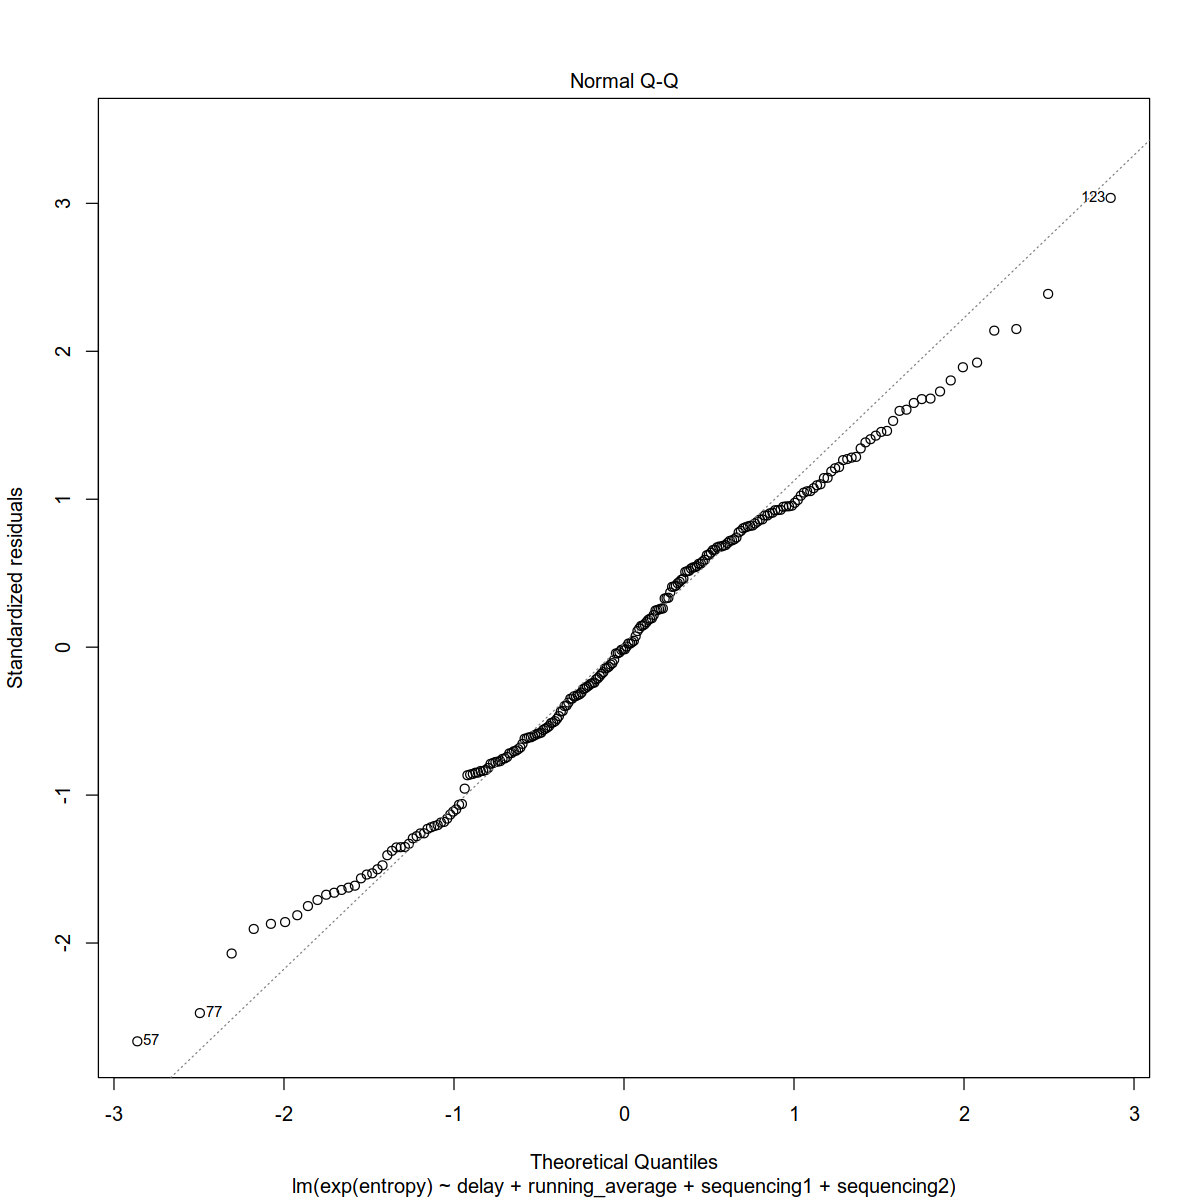

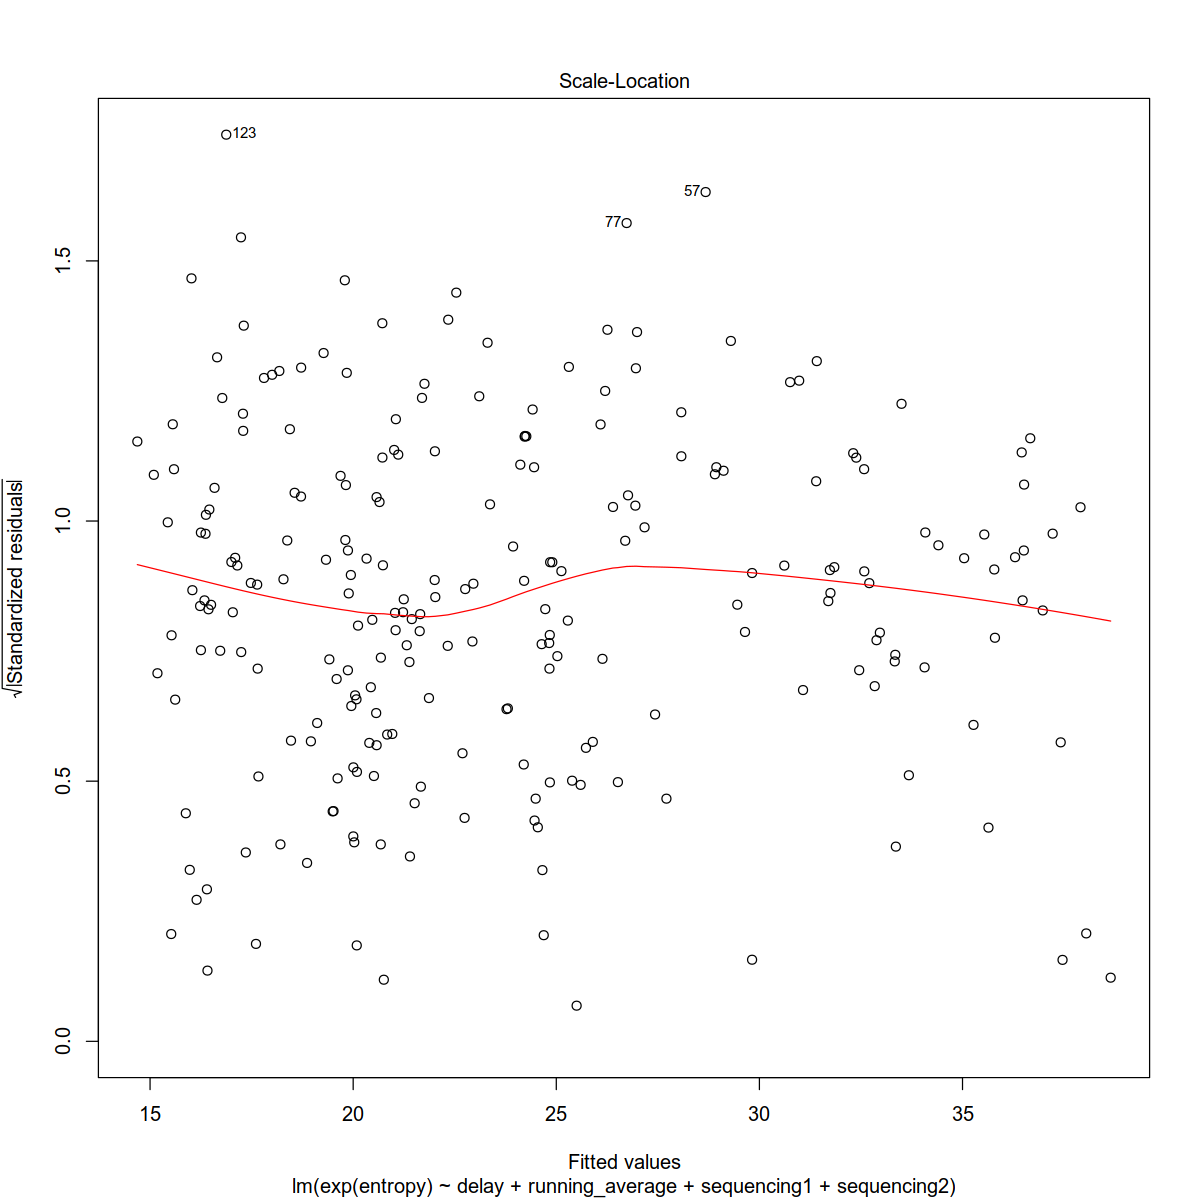

png 
  2

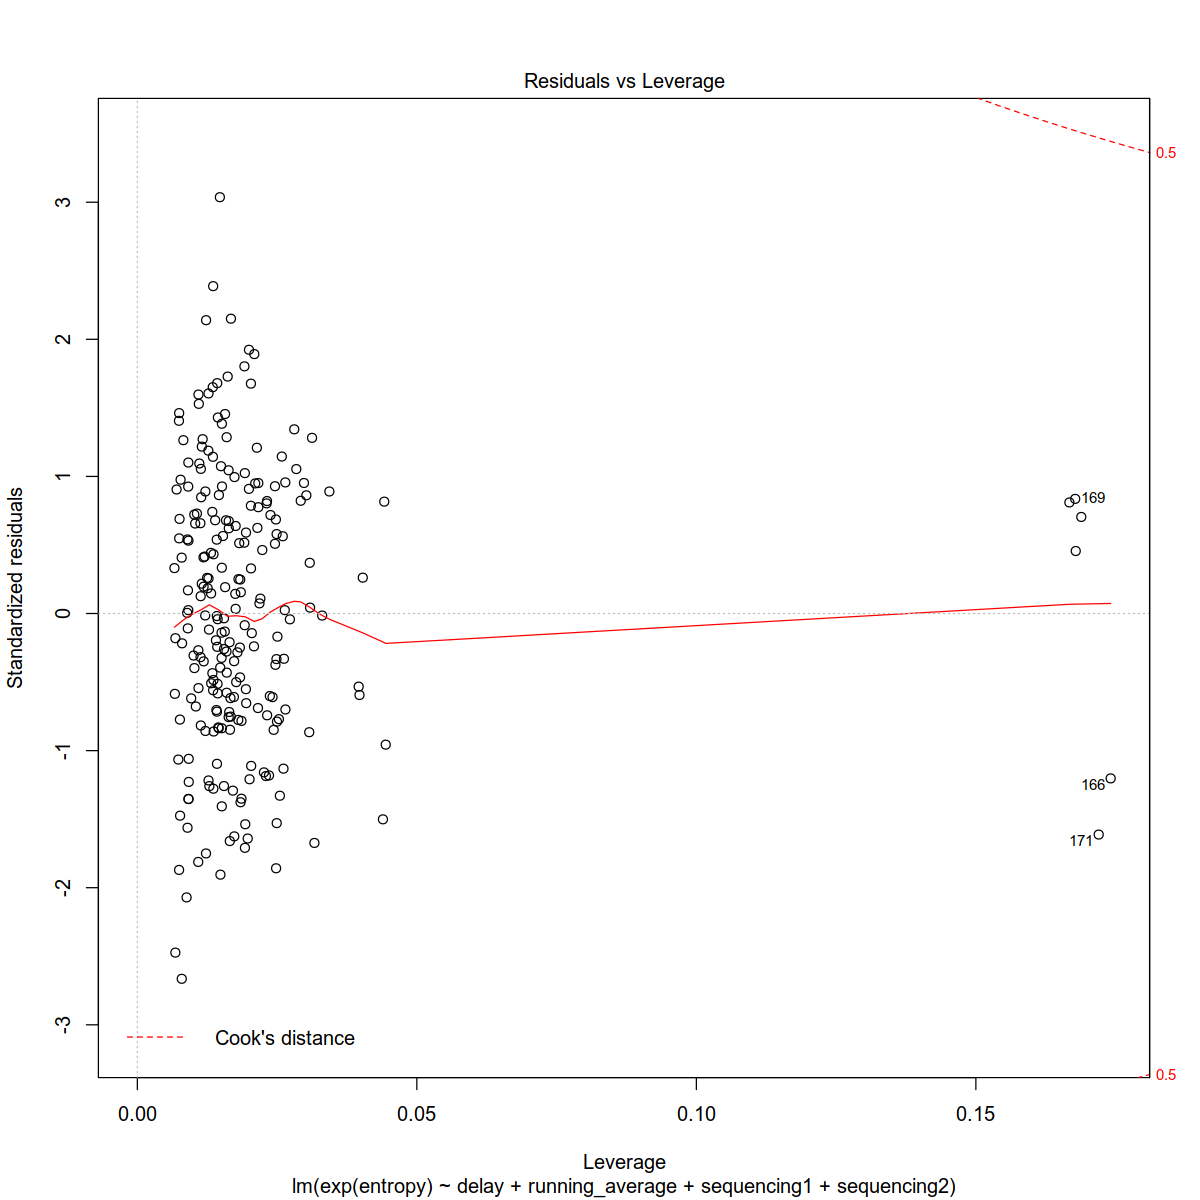

In [33]:
# fit exp(entropy) vs. all predictors 
lm_chur_multi_entropy_exp <- lm(exp(entropy) ~ delay+running_average+sequencing1+sequencing2, data = model_entropy_concentration_chur)
summary(lm_chur_multi_entropy_exp )
confint(lm_chur_multi_entropy_exp )

lm_laupen_multi_entropy_exp <- lm(exp(entropy) ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_laupen)
summary(lm_laupen_multi_entropy_exp)
confint(lm_laupen_multi_entropy_exp)

lm_zurich_multi_entropy_exp <- lm(exp(entropy)~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_zurich)
summary(lm_zurich_multi_entropy_exp)
confint(lm_zurich_multi_entropy_exp)

lm_altenrhein_multi_entropy_exp <- lm(exp(entropy) ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_altenrhein)
summary(lm_altenrhein_multi_entropy_exp)
confint(lm_altenrhein_multi_entropy_exp)

lm_lugano_multi_entropy_exp <- lm(exp(entropy) ~ delay + running_average+sequencing1+sequencing2, data = model_entropy_concentration_lugano)
summary(lm_lugano_multi_entropy_exp)
confint(lm_lugano_multi_entropy_exp)

 plot(lm_chur_multi_entropy_exp)
# plot(lm_laupen_multi_entropy_exp)
# plot(lm_zurich_multi_entropy_exp)
# plot(lm_altenrhein_multi_entropy_exp)
#plot(lm_lugano_multi_entropy_exp)

#plot residuals against time to verify the assumption of uncorrelated errors
cairo_ps(file = "FinalReport/figures/uncorrelated_errors_assumption2.eps", width = 12, height = 6)

plot(residuals(lm_chur_multi_entropy_exp) ~ model_entropy_concentration_chur$date, xlab="Date", ylab="Residuals", cex.lab = 1.7, cex.axis =1.5, xaxt = "n")
# Add a custom x-axis with more date labels
axis.Date(1, 
          at = seq(min(model_entropy_concentration_chur$date), max(model_entropy_concentration_chur$date), by = "2 month"), 
          format = "%b %Y", 
          cex.axis = 1.7)
abline(h=0)

dev.off()

In [34]:
# Coverage vs. predictors
lm_chur_multi_coverage_100 <- lm(coverage ~ delay + running_average + sequencing1+sequencing2, data = model_coverage_100_concentration_chur)
summary(lm_chur_multi_coverage_100)
confint(lm_chur_multi_coverage_100)

lm_laupen_multi_coverage_100 <- lm(coverage ~ delay + running_average + sequencing1+sequencing2, data = model_coverage_100_concentration_laupen)
summary(lm_laupen_multi_coverage_100)
confint(lm_laupen_multi_coverage_100)

lm_zurich_multi_coverage_100 <- lm(coverage ~ delay + running_average + sequencing1+sequencing2, data = model_coverage_100_concentration_zurich)
summary(lm_zurich_multi_coverage_100)
confint(lm_zurich_multi_coverage_100)

lm_altenrhein_multi_coverage_100 <- lm(coverage ~ delay + running_average + sequencing1+sequencing2, data = model_coverage_100_concentration_altenrhein)
summary(lm_altenrhein_multi_coverage_100)
confint(lm_altenrhein_multi_coverage_100)

lm_lugano_multi_coverage_100 <- lm(coverage ~ delay + running_average + sequencing1+sequencing2, data = model_coverage_100_concentration_lugano)
summary(lm_lugano_multi_coverage_100)
confint(lm_lugano_multi_coverage_100)




Call:
lm(formula = coverage ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_coverage_100_concentration_chur)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68566 -0.16594  0.01881  0.17922  0.55531 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.4870107  0.1087231   4.479 1.17e-05 ***
delay            0.0024374  0.0096510   0.253   0.8008    
running_average  0.0052938  0.0007943   6.664 1.90e-10 ***
sequencing1     -0.2245273  0.1043099  -2.153   0.0324 *  
sequencing2     -0.0969501  0.1031005  -0.940   0.3480    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2457 on 233 degrees of freedom
Multiple R-squared:  0.3018,	Adjusted R-squared:  0.2898 
F-statistic: 25.18 on 4 and 233 DF,  p-value: < 2.2e-16


2.5 %        97.5 %      
(Intercept)      0.272804653  0.701216830
delay           -0.016577003  0.021451889
running_average  0.003728791  0.006858739
sequencing1     -0.430038365 -0.019016289
sequencing2     -0.300078496  0.106178319


Call:
lm(formula = coverage ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_coverage_100_concentration_laupen)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53674 -0.14702  0.00277  0.16677  0.50686 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.352773   0.098353   3.587   0.0004 ***
delay           -0.015286   0.008840  -1.729   0.0850 .  
running_average  0.009511   0.001378   6.902 3.92e-11 ***
sequencing1     -0.161353   0.094311  -1.711   0.0883 .  
sequencing2      0.051641   0.095052   0.543   0.5874    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2396 on 260 degrees of freedom
Multiple R-squared:  0.4049,	Adjusted R-squared:  0.3957 
F-statistic: 44.22 on 4 and 260 DF,  p-value: < 2.2e-16


2.5 %        97.5 %    
(Intercept)      0.159103072 0.54644351
delay           -0.032692561 0.00212046
running_average  0.006797139 0.01222431
sequencing1     -0.347064515 0.02435779
sequencing2     -0.135527901 0.23881055


Call:
lm(formula = coverage ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_coverage_100_concentration_zurich)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76851 -0.17409  0.04788  0.14491  0.38856 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.8563086  0.0820586  10.435  < 2e-16 ***
delay           -0.0181056  0.0089093  -2.032 0.043189 *  
running_average  0.0011116  0.0004005   2.775 0.005935 ** 
sequencing1     -0.3047017  0.0778443  -3.914 0.000117 ***
sequencing2     -0.0937392  0.0788569  -1.189 0.235676    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1989 on 250 degrees of freedom
Multiple R-squared:  0.3055,	Adjusted R-squared:  0.2944 
F-statistic: 27.49 on 4 and 250 DF,  p-value: < 2.2e-16


2.5 %         97.5 %       
(Intercept)      0.6946943604  1.0179228541
delay           -0.0356524474 -0.0005587994
running_average  0.0003226952  0.0019004563
sequencing1     -0.4580159356 -0.1513875183
sequencing2     -0.2490478160  0.0615694368


Call:
lm(formula = coverage ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_coverage_100_concentration_altenrhein)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81402 -0.18234  0.05738  0.18971  0.47535 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.5729373  0.1009593   5.675 3.87e-08 ***
delay            0.0201108  0.0091208   2.205  0.02838 *  
running_average  0.0025993  0.0005316   4.890 1.82e-06 ***
sequencing1     -0.2862614  0.0947931  -3.020  0.00279 ** 
sequencing2     -0.0702633  0.0937919  -0.749  0.45449    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.241 on 247 degrees of freedom
Multiple R-squared:  0.3202,	Adjusted R-squared:  0.3092 
F-statistic: 29.09 on 4 and 247 DF,  p-value: < 2.2e-16


2.5 %        97.5 %      
(Intercept)      0.374086362  0.771788316
delay            0.002146271  0.038075280
running_average  0.001552280  0.003646301
sequencing1     -0.472967339 -0.099555392
sequencing2     -0.254997296  0.114470655


Call:
lm(formula = coverage ~ delay + running_average + sequencing1 + 
    sequencing2, data = model_coverage_100_concentration_lugano)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47534 -0.19215 -0.01576  0.17906  0.51169 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.627442   0.108931   5.760 2.93e-08 ***
delay           -0.013589   0.013416  -1.013 0.312276    
running_average -0.001126   0.001083  -1.040 0.299715    
sequencing1     -0.359561   0.103166  -3.485 0.000597 ***
sequencing2     -0.118973   0.101392  -1.173 0.241955    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2579 on 212 degrees of freedom
Multiple R-squared:  0.1507,	Adjusted R-squared:  0.1347 
F-statistic: 9.406 on 4 and 212 DF,  p-value: 5.115e-07


2.5 %        97.5 %      
(Intercept)      0.412715128  0.842168832
delay           -0.040035804  0.012857551
running_average -0.003261496  0.001009199
sequencing1     -0.562923963 -0.156198990
sequencing2     -0.318839413  0.080893393

In [35]:
#plot the diagnostic plot entropy vs. all in Chur
number = 28
residuals_fitted_chur_entropy <- autoplot(lm_chur_multi_entropy, which =1) + theme(
    plot.title = element_text(size = number),
    axis.title.x = element_text(size = number),  
    axis.title.y = element_text(size = number),  
    axis.text.x = element_text(size = number),   
    axis.text.y = element_text(size = number),
    plot.margin = margin(t = 0.5, r = 0.5, b = 0.5, l = 0.5, unit = "cm") 
  )

qq_plot_chur_entropy <- autoplot(lm_chur_multi_entropy, which =2) + theme(
    plot.title = element_text(size = number),
   axis.title.x = element_text(size = number),  
    axis.title.y = element_text(size = number), 
    axis.text.x = element_text(size = number),  
    axis.text.y = element_text(size = number)    
  )

cairo_ps(file = "FinalReport/figures/low_diag_entropy_chur.eps", width=12, height = 6)

#combine them in one plot 
low_diag_entropy_chur <- residuals_fitted_chur_entropy + qq_plot_chur_entropy 
print(low_diag_entropy_chur)

dev.off()
#__________________________________________________________________________________________________

#plot the diagnostic plots exp(entropy) vs. all in Chur
residuals_fitted_chur_entropy_exp <- autoplot(lm_chur_multi_entropy_exp, which =1) + theme(
    plot.title = element_text(size = number),
    axis.title.x = element_text(size = number),  
    axis.title.y = element_text(size = number),  
    axis.text.x = element_text(size = number),   
    axis.text.y = element_text(size = number),
    plot.margin = margin(t = 0.5, r = 0.5, b = 0.5, l = 0.5, unit = "cm") 
  )

qq_plot_chur_entropy_exp <- autoplot(lm_chur_multi_entropy_exp, which =2) + theme(
    plot.title = element_text(size = number),
   axis.title.x = element_text(size = number),  
    axis.title.y = element_text(size = number), 
    axis.text.x = element_text(size = number),  
    axis.text.y = element_text(size = number)    
  )

cairo_ps(file = "FinalReport/figures/low_diag_entropy_chur_exp.eps", width=12, height = 6)

#combine them in one plot 
low_diag_entropy_chur_exp <- residuals_fitted_chur_entropy_exp + qq_plot_chur_entropy_exp
print(low_diag_entropy_chur_exp)

dev.off()
#__________________________________________________________________________________________________

#plot the diagnostic plots coverage vs. all in Chur
residuals_fitted_chur_coverage <- autoplot(lm_chur_multi_coverage_100, which =1) + theme(
    plot.title = element_text(size = number),
    axis.title.x = element_text(size = number),  
    axis.title.y = element_text(size = number),  
    axis.text.x = element_text(size = number),   
    axis.text.y = element_text(size = number),
    plot.margin = margin(t = 0.5, r = 0.5, b = 0.5, l = 0.5, unit = "cm") 
  )

qq_plot_chur_coverage <- autoplot(lm_chur_multi_coverage_100, which =2) + theme(
    plot.title = element_text(size = number),
   axis.title.x = element_text(size = number),  
    axis.title.y = element_text(size = number), 
    axis.text.x = element_text(size = number),  
    axis.text.y = element_text(size = number)    
  )

cairo_ps(file = "FinalReport/figures/low_diag_chur_coverage.eps", width=12, height = 6)

#combine them in one plot 
low_diag_chur_coverage <- residuals_fitted_chur_coverage + qq_plot_chur_coverage
print(low_diag_chur_coverage)

dev.off()


png 
  2

png 
  2

png 
  2